# Upgrade PIP

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from PIL import Image
import tkinter as tk
from tkinter import filedialog, simpledialog
import argparse

# Create output directory
OUTPUT_DIR = os.path.join(os.path.expanduser("~"), "face_detection_output")
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_image_from_path(image_path=None):
    """Load an image from a specified path or prompt user to select one"""
    if image_path is None or not os.path.exists(image_path):
        # If no path provided or invalid path, use GUI to select file
        root = tk.Tk()
        root.withdraw()  # Hide the main window
        image_path = filedialog.askopenfilename(
            title="Select Image File",
            filetypes=[("Image files", "*.jpg *.jpeg *.png *.bmp")]
        )
        if not image_path:  # User canceled
            print("No image selected. Exiting.")
            exit()
    
    try:
        # Load the image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not read image from {image_path}")
        
        # Save a copy of the original image
        original_path = os.path.join(OUTPUT_DIR, "original_image.jpg")
        cv2.imwrite(original_path, image)
        print(f"Original image saved to {original_path}")
        
        # Create a bounding box for the face
        h, w = image.shape[:2]
        
        # Ask user if they want to manually specify the bounding box
        root = tk.Tk()
        root.withdraw()
        manual_bbox = tk.messagebox.askyesno(
            "Bounding Box Selection",
            "Do you want to manually specify the bounding box coordinates?\n"
            "If no, a default box will be created."
        )
        
        if manual_bbox:
            # Ask for coordinates
            x1 = simpledialog.askinteger("Bounding Box", "Enter left (x1) coordinate:", 
                                         minvalue=0, maxvalue=w-1)
            y1 = simpledialog.askinteger("Bounding Box", "Enter top (y1) coordinate:", 
                                         minvalue=0, maxvalue=h-1)
            x2 = simpledialog.askinteger("Bounding Box", "Enter right (x2) coordinate:", 
                                         minvalue=x1+1, maxvalue=w)
            y2 = simpledialog.askinteger("Bounding Box", "Enter bottom (y2) coordinate:", 
                                         minvalue=y1+1, maxvalue=h)
            bbox = [x1, y1, x2, y2]
        else:
            # Create a default bounding box (center 60% of the image)
            x1 = int(w * 0.2)
            y1 = int(h * 0.2)
            x2 = int(w * 0.8)
            y2 = int(h * 0.8)
            bbox = [x1, y1, x2, y2]
        
        # Draw the bounding box on a copy of the image and save it
        img_with_bbox = image.copy()
        cv2.rectangle(img_with_bbox, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        bbox_path = os.path.join(OUTPUT_DIR, "image_with_bbox.jpg")
        cv2.imwrite(bbox_path, img_with_bbox)
        print(f"Image with bounding box saved to {bbox_path}")
        
        return image, bbox
        
    except Exception as e:
        print(f"Error loading image: {e}")
        print("Using fallback synthetic image instead.")
        return create_face_image(size=512)

def create_face_image(size=416):
    """Create a sample face image with a bounding box (fallback)"""
    # Create a blank image
    img = np.ones((size, size, 3), dtype=np.uint8) * 240
    
    # Draw a face
    center_x, center_y = size // 2, size // 2
    face_radius = size // 4
    
    # Draw face circle
    cv2.circle(img, (center_x, center_y), face_radius, (220, 210, 200), -1)
    
    # Draw eyes
    eye_radius = face_radius // 5
    left_eye_x = center_x - face_radius // 2
    right_eye_x = center_x + face_radius // 2
    eye_y = center_y - face_radius // 5
    
    cv2.circle(img, (left_eye_x, eye_y), eye_radius, (80, 80, 80), -1)
    cv2.circle(img, (right_eye_x, eye_y), eye_radius, (80, 80, 80), -1)
    
    # Draw eyebrows
    eyebrow_y = eye_y - eye_radius * 2
    cv2.line(img, (left_eye_x - eye_radius, eyebrow_y), 
             (left_eye_x + eye_radius, eyebrow_y), (60, 60, 60), 2)
    cv2.line(img, (right_eye_x - eye_radius, eyebrow_y), 
             (right_eye_x + eye_radius, eyebrow_y), (60, 60, 60), 2)
    
    # Draw nose
    nose_top_y = eye_y + eye_radius
    nose_bottom_y = center_y + face_radius // 4
    
    cv2.line(img, (center_x, nose_top_y), (center_x, nose_bottom_y), (120, 110, 110), 3)
    cv2.line(img, (center_x - eye_radius//2, nose_bottom_y), 
             (center_x + eye_radius//2, nose_bottom_y), (120, 110, 110), 2)
    
    # Draw mouth
    mouth_y = center_y + face_radius // 2
    mouth_width = face_radius
    
    cv2.ellipse(img, (center_x, mouth_y), (mouth_width // 2, face_radius // 6), 
                0, 0, 180, (150, 80, 80), -1)
    
    # Create bounding box
    box_margin = face_radius // 4
    x1 = center_x - face_radius - box_margin
    y1 = center_y - face_radius - box_margin
    x2 = center_x + face_radius + box_margin
    y2 = center_y + face_radius + box_margin
    
    # Ensure box is within image boundaries
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(size - 1, x2)
    y2 = min(size - 1, y2)
    
    return img, [x1, y1, x2, y2]

def visualize_augmentations_grid(image, bbox):
    """Create a grid of augmented images showing each transformation"""
    # Define individual augmentations to visualize
    augmentations = [
        ("Original", None),
        ("HorizontalFlip", A.HorizontalFlip(p=1.0)),
        ("RandomBrightnessContrast", A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1.0)),
        ("Rotate", A.Rotate(limit=30, p=1.0)),
        ("Scale", A.Affine(scale=(0.8, 1.2), p=1.0)),
        ("Translate", A.Affine(translate_percent={"x": 0.1, "y": 0.1}, p=1.0)),
        ("GaussianBlur", A.GaussianBlur(blur_limit=7, p=1.0)),
        ("GaussNoise", A.GaussNoise(var_limit=50.0, p=1.0)),
        ("ColorJitter", A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1.0)),
        ("RandomShadow", A.RandomShadow(p=1.0)),
        ("RandomFog", A.RandomFog(fog_coef_lower=0.3, fog_coef_upper=0.5, p=1.0)),
        ("CLAHE", A.CLAHE(p=1.0)),
        ("RandomRain", A.RandomRain(p=1.0)),
        ("RandomSnow", A.RandomSnow(p=1.0)),
        ("RandomSunFlare", A.RandomSunFlare(p=1.0)),
        ("MotionBlur", A.MotionBlur(p=1.0))
    ]
    
    # Create a grid of augmented images
    n_cols = 4
    n_rows = (len(augmentations) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, n_rows * 4))
    
    for i, (aug_name, aug) in enumerate(augmentations):
        plt.subplot(n_rows, n_cols, i + 1)
        
        if aug is None:
            # Original image
            img_display = image.copy()
            box = bbox
        else:
            # Apply augmentation
            try:
                transform = A.Compose([aug], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))
                transformed = transform(image=image.copy(), bboxes=[bbox], class_labels=['face'])
                img_display = transformed['image']
                
                if transformed['bboxes']:
                    box = transformed['bboxes'][0]
                    # Draw the transformed bounding box
                    cv2.rectangle(img_display, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255), 2)
                else:
                    # If bounding box was lost, use original
                    box = bbox
                    cv2.rectangle(img_display, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)
            except Exception as e:
                print(f"Error applying {aug_name}: {e}")
                img_display = image.copy()
                box = bbox
                cv2.rectangle(img_display, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)
        
        plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
        plt.title(aug_name)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "image_augmentations_grid.png"))
    plt.close()
    
    print(f"Augmentations grid saved to {os.path.join(OUTPUT_DIR, 'image_augmentations_grid.png')}")
    return os.path.join(OUTPUT_DIR, "image_augmentations_grid.png")

def visualize_augmentation_sequence(image, bbox):
    """Visualize a sequence of augmentations applied to the same image"""
    # Define a sequence of augmentations
    aug_sequence = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Affine(scale=(0.9, 1.1), translate_percent=0.1, rotate=(-10, 10), p=0.5),
        A.GaussianBlur(p=0.3),
        A.GaussNoise(p=0.3),
        A.RandomShadow(p=0.3),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))
    
    # Apply the sequence multiple times
    n_samples = 9
    plt.figure(figsize=(15, 15))
    
    # Show original image
    plt.subplot(3, 3, 1)
    img_display = image.copy()
    cv2.rectangle(img_display, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis('off')
    
    # Show augmented samples
    for i in range(n_samples - 1):
        plt.subplot(3, 3, i + 2)
        
        # Apply augmentation
        transformed = aug_sequence(image=image.copy(), bboxes=[bbox], class_labels=['face'])
        img_display = transformed['image']
        
        if transformed['bboxes']:
            box = transformed['bboxes'][0]
            # Draw the transformed bounding box
            cv2.rectangle(img_display, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255), 2)
        
        plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
        plt.title(f"Augmented Sample {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "image_augmentation_sequence.png"))
    plt.close()
    
    print(f"Augmentation sequence visualization saved to {os.path.join(OUTPUT_DIR, 'image_augmentation_sequence.png')}")
    return os.path.join(OUTPUT_DIR, "image_augmentation_sequence.png")

def visualize_advanced_augmentations(image, bbox):
    """Create visualizations of more advanced augmentations"""
    # Define advanced augmentations
    advanced_augmentations = [
        ("Original", None),
        ("ElasticTransform", A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)),
        ("GridDistortion", A.GridDistortion(p=1.0)),
        ("OpticalDistortion", A.OpticalDistortion(distort_limit=0.5, shift_limit=0.5, p=1.0)),
        ("Perspective", A.Perspective(scale=(0.05, 0.1), p=1.0)),
        ("PixelDropout", A.PixelDropout(dropout_prob=0.01, p=1.0)),
        ("RandomToneCurve", A.RandomToneCurve(p=1.0)),
        ("Superpixels", A.Superpixels(p_replace=0.1, n_segments=100, p=1.0)),
        ("ChannelShuffle", A.ChannelShuffle(p=1.0)),
        ("RGBShift", A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=1.0)),
        ("HueSaturationValue", A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1.0)),
        ("Posterize", A.Posterize(p=1.0)),
        ("Solarize", A.Solarize(p=1.0)),
        ("Equalize", A.Equalize(p=1.0)),
        ("Emboss", A.Emboss(p=1.0)),
        ("Sharpen", A.Sharpen(p=1.0))
    ]
    
    # Create a grid of augmented images
    n_cols = 4
    n_rows = (len(advanced_augmentations) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, n_rows * 4))
    
    for i, (aug_name, aug) in enumerate(advanced_augmentations):
        plt.subplot(n_rows, n_cols, i + 1)
        
        if aug is None:
            # Original image
            img_display = image.copy()
            box = bbox
        else:
            # Apply augmentation
            try:
                transform = A.Compose([aug], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))
                transformed = transform(image=image.copy(), bboxes=[bbox], class_labels=['face'])
                img_display = transformed['image']
                
                if transformed['bboxes']:
                    box = transformed['bboxes'][0]
                    # Draw the transformed bounding box
                    cv2.rectangle(img_display, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255), 2)
                else:
                    # If bounding box was lost, use original
                    box = bbox
                    cv2.rectangle(img_display, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)
            except Exception as e:
                print(f"Error applying {aug_name}: {e}")
                img_display = image.copy()
                box = bbox
                cv2.rectangle(img_display, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)
        
        plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
        plt.title(aug_name)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "advanced_augmentations.png"))
    plt.close()
    
    print(f"Advanced augmentations saved to {os.path.join(OUTPUT_DIR, 'advanced_augmentations.png')}")
    return os.path.join(OUTPUT_DIR, "advanced_augmentations.png")

def main():
    # Parse command line arguments
    parser = argparse.ArgumentParser(description='Apply and visualize image augmentations')
    parser.add_argument('--image', type=str, help='Path to the input image file', default=None)
    args = parser.parse_args()
    
    print("Visualizing Albumentations augmentations on your image...")
    print(f"Output directory: {OUTPUT_DIR}")
    
    # Load image from specified path or prompt user to select one
    image, bbox = load_image_from_path(args.image)
    
    # Create grid of individual augmentations
    grid_path = visualize_augmentations_grid(image, bbox)
    
    # Create sequence of augmentations
    sequence_path = visualize_augmentation_sequence(image, bbox)
    
    # Create advanced augmentations
    advanced_path = visualize_advanced_augmentations(image, bbox)
    
    print("\nSummary of generated visualizations:")
    print(f"1. Augmentations Grid: {grid_path}")
    print(f"2. Augmentation Sequence: {sequence_path}")
    print(f"3. Advanced Augmentations: {advanced_path}")
    print(f"\nAll visualizations have been saved to: {OUTPUT_DIR}")

if __name__ == "__main__":
    main()

usage: ipykernel_launcher.py [-h] [--image IMAGE]
ipykernel_launcher.py: error: unrecognized arguments: --f=c:\Users\DELL\AppData\Roaming\jupyter\runtime\kernel-v38e19a758ee82927473bd6624cfec7e2428bfd95f.json


SystemExit: 2

C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


# Install Flask

In [ ]:
!pip install --upgrade --ignore-installed blinker Flask

# Install Flask-WTF

In [ ]:
pip install Flask-WTF

# Extracting the ZIP File

In [ ]:
import zipfile
import os

# Path to your zip file
zip_path = '/content/PlantAI.zip'
extract_path = '/content/Extract'

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check if the extraction worked
print(os.listdir(extract_path))

['Image data']


# Image Data Generator

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image dimensions and batch size
img_width, img_height = 150, 150
batch_size = 32

# Image Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Ensure the paths to your data directories are correct
train_dir = '/content/Extract/Image data/train'
val_dir = '/content/Extract/Image data/validation'
test_dir = '/content/Extract/Image data/test'

# Train data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation data generator
validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Generally set to False for test data
)

Found 31032 images belonging to 40 classes.
Found 8137 images belonging to 40 classes.
Found 4762 images belonging to 40 classes.


# Check for Missing Images

In [ ]:
import os

# Path to your dataset directories
extract_path = '/content/Extract'
train_dir = os.path.join(extract_path, 'Image data', 'train')
val_dir = os.path.join(extract_path, 'Image data', 'validation')
test_dir = os.path.join(extract_path, 'Image data', 'test')

# Expected counts for train, validation, and test folders
expected_counts = {
    'Image data/train': 31032,
    'Image data/validation': 8137,
    'Image data/test': 4762
}

# Function to count the number of images in a given directory
def count_images_in_directory(directory):
    total_images = 0
    for root, _, files in os.walk(directory):
        total_images += len([f for f in files if os.path.isfile(os.path.join(root, f))])
    return total_images

# Checking each directory for missing images
missing_images_report = {}

for folder, expected_count in expected_counts.items():
    folder_path = os.path.join(extract_path, folder)
    if not os.path.exists(folder_path):
        print(f"Warning: {folder_path} does not exist.")
        missing_images_report[folder] = f"Directory not found"
        continue

    # Count actual images
    actual_count = count_images_in_directory(folder_path)
    missing_count = expected_count - actual_count

    # Report if images are missing
    if missing_count > 0:
        missing_images_report[folder] = f"{missing_count} images are missing"
    elif missing_count < 0:
        missing_images_report[folder] = f"{abs(missing_count)} extra images found"
    else:
        missing_images_report[folder] = "All images are present"

# Display missing images report
print("Missing Images Report:")
for folder, report in missing_images_report.items():
    print(f"{folder:25}: {report}")

Missing Images Report:
Image data/train         : All images are present
Image data/validation    : All images are present
Image data/test          : All images are present


# Checking Total Classes

In [ ]:
import tensorflow as tf

# Function to load a dataset from a directory
def load_dataset(directory, batch_size=32, image_size=(224, 224), shuffle=True):
    return tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        image_size=image_size,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=123 if shuffle else None  # Set seed only if shuffling
    )

# Load the training and validation datasets
training_set = load_dataset("/content/Extract/Image data/train", shuffle=True)
validation_set = load_dataset("/content/Extract/Image data/validation", shuffle=False)

# Retrieve class names from both datasets
class_names_train = training_set.class_names
class_names_val = validation_set.class_names

# Combine the class names from both training and validation sets, and remove duplicates
all_class_names = set(class_names_train).union(set(class_names_val))

# Separate classes into 'healthy' and 'diseases'
healthy_classes = [class_name for class_name in all_class_names if 'healthy' in class_name.lower()]
disease_classes = [class_name for class_name in all_class_names if 'healthy' not in class_name.lower()]

# Print the classes and total counts
print("Healthy Classes:")
for healthy_class in sorted(healthy_classes):
    print(f"- {healthy_class}")

print("\nDisease Classes:")
for disease_class in sorted(disease_classes):
    print(f"- {disease_class}")

print(f"\nTotal number of healthy classes: {len(healthy_classes)}")
print(f"Total number of disease classes: {len(disease_classes)}")
print(f"Total number of unique classes: {len(all_class_names)}")

Found 31032 files belonging to 40 classes.
Found 8137 files belonging to 40 classes.
Healthy Classes:
- Apple healthy
- Cassava Healthy
- Cherry healthy
- Corn healthy
- Grape healthy
- Peach healthy
- Potato healthy
- Rice Healthy
- Strawberry healthy
- Tomato healthy

Disease Classes:
- Apple black rot
- Apple cedar apple rust
- Apple scab
- Cassava Bacterial Blight (CBB)
- Cassava Brown Streak Disease (CBSD)
- Cassava Green Mottle (CGM)
- Cassava Mosaic Disease (CMD)
- Cherry powdery mildew
- Corn cercospora leaf spot gray leaf spot
- Corn common rust
- Corn northern leaf blight
- Grape black rot
- Grape esca (black measles)
- Grape leaf blight (isariopsis leaf spot)
- Peach bacterial spot
- Potato early blight
- Potato late blight
- Rice BrownSpot
- Rice Hispa
- Rice LeafBlast
- Strawberry leaf scorch
- Tomato bacterial spot
- Tomato early blight
- Tomato late blight
- Tomato leaf mold
- Tomato mosaic virus
- Tomato septoria leaf spot
- Tomato spider mites two-spotted spider mite
-

# Checking Total Images

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Define paths to the directories
extract_path = '/content/Extract/Image data'
TRAIN_DIR = os.path.join(extract_path, 'train')
VAL_DIR = os.path.join(extract_path, 'validation')
TEST_DIR = os.path.join(extract_path, 'test')

# Image dimensions and batch size
img_width, img_height = 150, 150
batch_size = 32

# Helper function to count images in a directory
def count_images_in_directory(directory):
    total_images = 0
    for root, dirs, files in os.walk(directory):
        img_count = len([f for f in files if os.path.isfile(os.path.join(root, f))])
        total_images += img_count
        if img_count > 0:
            relative_folder = os.path.relpath(root, directory)
            print(f'{relative_folder:50} : {img_count}')
    return total_images

# Count and display the number of images in each set
print("\nTraining Set:")
total_train_images = count_images_in_directory(TRAIN_DIR)
print(f'\nTotal training images: {total_train_images}')

print("\nValidation Set:")
total_val_images = count_images_in_directory(VAL_DIR)
print(f'\nTotal validation images: {total_val_images}')

print("\nTest Set:")
total_test_images = count_images_in_directory(TEST_DIR)
print(f'\nTotal test images: {total_test_images}')


Training Set:
Tomato early blight                                : 720
Tomato leaf mold                                   : 686
Rice Healthy                                       : 1072
Tomato yellow leaf curl virus                      : 3858
Potato early blight                                : 720
Apple scab                                         : 454
Apple cedar apple rust                             : 199
Tomato healthy                                     : 1146
Grape esca (black measles)                         : 996
Grape black rot                                    : 850
Rice BrownSpot                                     : 377
Tomato target spot                                 : 1012
Apple healthy                                      : 1185
Peach bacterial spot                               : 1655
Peach healthy                                      : 260
Potato late blight                                 : 720
Cassava Brown Streak Disease (CBSD)                : 372
Tomato lat

# Displaying Train and Validation Images

Train Images


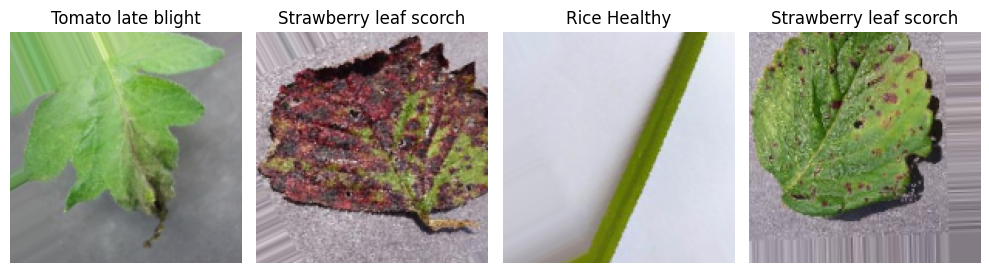

Validation Images


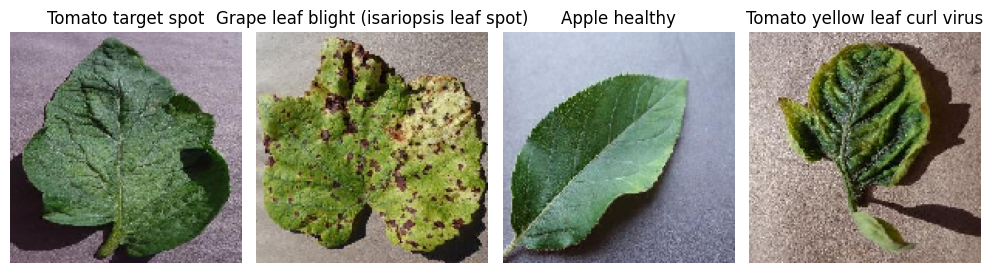

In [ ]:
import matplotlib.pyplot as plt

# Function to plot images with their corresponding folder and subfolder names
def plot_images(data_gen, num_images=4):  # Set num_images=4 for a grid of 2x2
    """Plot a grid of images from the data generator with their folder names."""
    plt.figure(figsize=(10, 10))

    # Get the next batch of images and their labels
    img, labels = next(data_gen)  # Get the next batch of images
    class_indices = data_gen.class_indices  # Get the mapping of class indices to class labels
    class_labels = list(class_indices.keys())  # Get the class labels as a list

    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)  # 1 row, num_images columns
        plt.imshow(img[i])  # Display the i-th image in the batch
        plt.axis("off")  # Hide axis

        # Get the class index of the current image and its corresponding label
        class_index = labels[i].argmax()  # Find the index of the class with the highest probability
        folder_name = class_labels[class_index]  # Get the folder name based on the index

        # Set the title as the folder name
        ax.set_title(f"{folder_name}")  # Set the title as the folder/subfolder name

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Plot some images from the training data generator, showing 4 images
print("Train Images")
plot_images(train_generator, num_images=4)

# Plot some images from the validation data generator, showing 4 images
print("Validation Images")
plot_images(validation_generator, num_images=4)

# Train Images Pre-Processing

In [ ]:
import os
import cv2
import numpy as np
from pathlib import Path
import time
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_image(image_path):
    """Load image from a file."""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found or invalid at path: {image_path}")
    return image

def remove_background(image):
    """Remove background using a mask based on a color threshold."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
    foreground = cv2.bitwise_and(image, image, mask=mask)
    return foreground

def apply_histogram_equalization(image):
    """Apply histogram equalization to enhance contrast."""
    return cv2.equalizeHist(image)

def resize_image(image, target_size):
    """Resize image to a fixed size using INTER_AREA for better quality when resizing."""
    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

def crop_image(image, crop_size=(224, 224)):
    """Crop the image to the center with a specified crop size."""
    h, w = image.shape[:2]
    start_x = w // 2 - (crop_size[0] // 2)
    start_y = h // 2 - (crop_size[1] // 2)
    return image[start_y:start_y+crop_size[1], start_x:start_x+crop_size[0]]

def normalize_pixel_values(image):
    """Normalize pixel values to the range [0, 1]."""
    return image.astype(np.float32) / 255.0

def preprocess_image(image_path, output_path, target_size=(224, 224)):
    """Preprocess the image by removing background, applying histogram equalization to each channel, cropping, resizing, and normalizing pixel values."""
    image = load_image(image_path)

    # Step 1: Background Removal
    image = remove_background(image)

    # Step 2: Histogram Equalization on each color channel
    channels = cv2.split(image)
    equalized_channels = [apply_histogram_equalization(channel) for channel in channels]
    image = cv2.merge(equalized_channels)

    # Step 3: Cropping Image to the Center
    image = crop_image(image, crop_size=target_size)

    # Step 4: Resizing Image to the Target Size
    image = resize_image(image, target_size)

    # Step 5: Normalizing Pixel Values (scale pixel values to [0, 1])
    image_normalized = normalize_pixel_values(image)

    # Save the preprocessed image in the output directory
    cv2.imwrite(str(output_path), (image_normalized * 255).astype(np.uint8))
    return image_normalized

def is_valid_image(file_path):
    """Check if a file is a valid image."""
    try:
        img = cv2.imread(str(file_path))
        return img is not None
    except Exception:
        return False

def preprocess_dataset(input_folder, output_folder, target_size=(224, 224)):
    """Preprocess all images in the dataset by applying background removal, histogram equalization, cropping, resizing, and pixel normalization."""
    input_path = Path(input_folder)
    output_path = Path(output_folder)
    output_path.mkdir(parents=True, exist_ok=True)

    image_extensions = {'.jpg', '.jpeg', '.png'}

    total_images = 0
    processed_images = 0

    for subdir, dirs, files in os.walk(input_path):
        for file in files:
            if file.lower().endswith(tuple(image_extensions)):
                total_images += 1

                img_path = Path(subdir) / file
                relative_path = img_path.relative_to(input_path)
                output_img_path = output_path / relative_path

                # Create necessary subdirectories in the output path
                output_img_path.parent.mkdir(parents=True, exist_ok=True)

                try:
                    if is_valid_image(img_path):
                        preprocess_image(str(img_path), str(output_img_path), target_size)
                        processed_images += 1

                        if processed_images % 10 == 0:
                            logging.info(f"Processed {processed_images}/{total_images}: {relative_path}")
                    else:
                        logging.warning(f"Skipped invalid image: {relative_path}")
                except Exception as e:
                    logging.error(f"Error processing {relative_path}: {str(e)}")

    logging.info(f"Total images found: {total_images}")
    logging.info(f"Total images processed: {processed_images}")

    # Print the number of preprocessed images
    print(f"Total number of images preprocessed: {processed_images}")

    if processed_images == 0:
        logging.warning("No images were processed. Check your input folder and image files.")

if __name__ == "__main__":
    input_folder = "/content/Extract/Image data/train"  # Adjust this to your main input folder
    output_folder = "/content/Pre-Processed_Images/Preprocessed_Images_Train"
    target_size = (224, 224)

    start_time = time.time()

    logging.info(f"Starting preprocessing. Input folder: {input_folder}")

    preprocess_dataset(input_folder, output_folder, target_size)

    end_time = time.time()
    logging.info(f"Preprocessing completed. Total time: {end_time - start_time:.2f} seconds")

Total number of images preprocessed: 31032


# Validation Images Pre-Processing

In [ ]:
import os
import cv2
import numpy as np
from pathlib import Path
import time
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_image(image_path):
    """Load image from a file."""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found or invalid at path: {image_path}")
    return image

def remove_background(image):
    """Remove background using a mask based on a color threshold."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
    foreground = cv2.bitwise_and(image, image, mask=mask)
    return foreground

def apply_histogram_equalization(image):
    """Apply histogram equalization to enhance contrast."""
    return cv2.equalizeHist(image)

def resize_image(image, target_size):
    """Resize image to a fixed size using INTER_AREA for better quality when resizing."""
    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

def crop_image(image, crop_size=(224, 224)):
    """Crop the image to the center with a specified crop size."""
    h, w = image.shape[:2]
    start_x = w // 2 - (crop_size[0] // 2)
    start_y = h // 2 - (crop_size[1] // 2)
    return image[start_y:start_y+crop_size[1], start_x:start_x+crop_size[0]]

def normalize_pixel_values(image):
    """Normalize pixel values to the range [0, 1]."""
    return image.astype(np.float32) / 255.0

def preprocess_image(image_path, output_path, target_size=(224, 224)):
    """Preprocess the image by removing background, applying histogram equalization to each channel, cropping, resizing, and normalizing pixel values."""
    image = load_image(image_path)

    # Step 1: Background Removal
    image = remove_background(image)

    # Step 2: Histogram Equalization on each color channel
    channels = cv2.split(image)
    equalized_channels = [apply_histogram_equalization(channel) for channel in channels]
    image = cv2.merge(equalized_channels)

    # Step 3: Cropping Image to the Center
    image = crop_image(image, crop_size=target_size)

    # Step 4: Resizing Image to the Target Size
    image = resize_image(image, target_size)

    # Step 5: Normalizing Pixel Values (scale pixel values to [0, 1])
    image_normalized = normalize_pixel_values(image)

    # Save the preprocessed image in the output directory
    cv2.imwrite(str(output_path), (image_normalized * 255).astype(np.uint8))
    return image_normalized

def is_valid_image(file_path):
    """Check if a file is a valid image."""
    try:
        img = cv2.imread(str(file_path))
        return img is not None
    except Exception:
        return False

def preprocess_dataset(input_folder, output_folder, target_size=(224, 224)):
    """Preprocess all images in the dataset by applying background removal, histogram equalization, cropping, resizing, and pixel normalization."""
    input_path = Path(input_folder)
    output_path = Path(output_folder)
    output_path.mkdir(parents=True, exist_ok=True)

    image_extensions = {'.jpg', '.jpeg', '.png'}

    total_images = 0
    processed_images = 0

    for subdir, dirs, files in os.walk(input_path):
        for file in files:
            if file.lower().endswith(tuple(image_extensions)):
                total_images += 1

                img_path = Path(subdir) / file
                relative_path = img_path.relative_to(input_path)
                output_img_path = output_path / relative_path

                # Create necessary subdirectories in the output path
                output_img_path.parent.mkdir(parents=True, exist_ok=True)

                try:
                    if is_valid_image(img_path):
                        preprocess_image(str(img_path), str(output_img_path), target_size)
                        processed_images += 1

                        if processed_images % 10 == 0:
                            logging.info(f"Processed {processed_images}/{total_images}: {relative_path}")
                    else:
                        logging.warning(f"Skipped invalid image: {relative_path}")
                except Exception as e:
                    logging.error(f"Error processing {relative_path}: {str(e)}")

    logging.info(f"Total images found: {total_images}")
    logging.info(f"Total images processed: {processed_images}")

    # Print the number of preprocessed images
    print(f"Total number of images preprocessed: {processed_images}")

    if processed_images == 0:
        logging.warning("No images were processed. Check your input folder and image files.")

if __name__ == "__main__":
    input_folder = "/content/Extract/Image data/validation"  # Adjust this to your main input folder
    output_folder = "/content/Pre-Processed_Images/Preprocessed_Images_Validation"
    target_size = (224, 224)

    start_time = time.time()

    logging.info(f"Starting preprocessing. Input folder: {input_folder}")

    preprocess_dataset(input_folder, output_folder, target_size)

    end_time = time.time()
    logging.info(f"Preprocessing completed. Total time: {end_time - start_time:.2f} seconds") # 1m 12s

Total number of images preprocessed: 8137


# Displaying Train and Validation Images after Pre-Processing

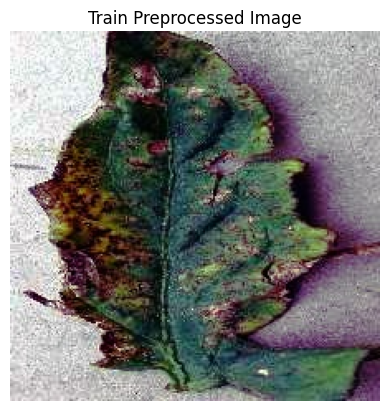

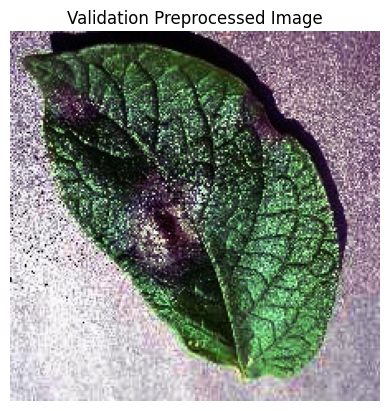

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt

def display_random_preprocessed_image(output_folder, title="Preprocessed Image"):
    """Display a random preprocessed image from the specified folder."""
    # Gather all image paths in the output folder
    preprocessed_images = []
    for root, dirs, files in os.walk(output_folder):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                preprocessed_images.append(os.path.join(root, file))

    if not preprocessed_images:
        print("No preprocessed images found in the specified folder.")
        return

    # Select a random image
    random_image_path = random.choice(preprocessed_images)

    # Load and display the selected image
    image = cv2.imread(random_image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for display

    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(title)
    plt.show()

# Define paths to the output folders
train_folder = "/content/Pre-Processed_Images/Preprocessed_Images_Train"
validation_folder = "/content/Pre-Processed_Images/Preprocessed_Images_Validation"

# Display a random preprocessed image from the training set
display_random_preprocessed_image(train_folder, title="Train Preprocessed Image")

# Display a random preprocessed image from the validation set
display_random_preprocessed_image(validation_folder, title="Validation Preprocessed Image")

# Normalization for Train and Validation Images

Found 31032 files belonging to 40 classes.
Found 8137 files belonging to 40 classes.


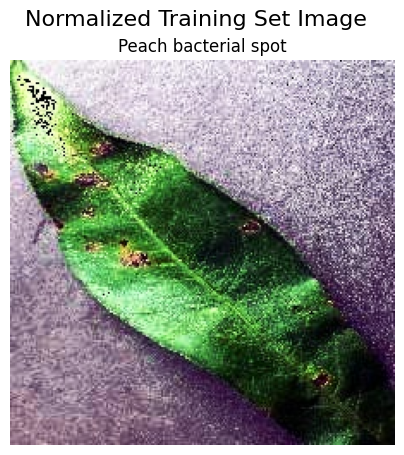

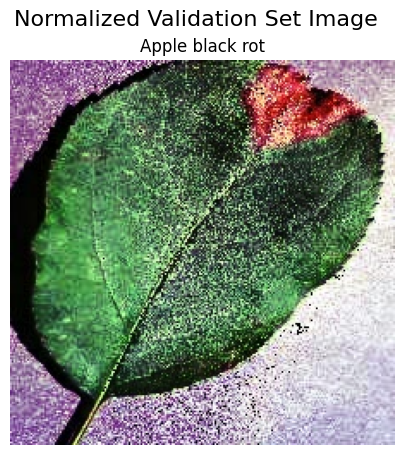

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Rescaling
import matplotlib.pyplot as plt

# Function to apply normalization using the Rescaling layer
def normalize_dataset(dataset):
    normalization_layer = Rescaling(1.0 / 255)
    normalized_dataset = dataset.map(lambda x, y: (normalization_layer(x), y))
    return normalized_dataset

# Function to load a dataset from a directory
def load_dataset(directory, batch_size=32, image_size=(224, 224), shuffle=True):
    return tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        image_size=image_size,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=123 if shuffle else None  # Set seed only if shuffling
    )

# Function to display a sample of images from a dataset with their disease names
def display_sample_images(dataset, class_names, title, num_images=1):  # Set num_images to 1
    plt.figure(figsize=(5, 5))  # Set the figure size

    for images, labels in dataset.take(1):  # Take one batch from the dataset
        for i in range(num_images):  # Display 'num_images' images
            ax = plt.subplot(1, 1, 1)  # 1 row, 1 column (for 1 image)
            plt.imshow((images[i].numpy() * 255.0).astype("uint8"))
            plt.title(f"{class_names[labels[i].numpy()]}")  # Show the disease name
            plt.axis("off")  # Turn off axis display

    plt.suptitle(title, fontsize=16)  # Add a title to the figure
    plt.show()

# Load and normalize the training dataset
training_set = load_dataset("/content/Pre-Processed_Images/Preprocessed_Images_Train", shuffle=True)
normalized_training_set = normalize_dataset(training_set)
class_names_train = training_set.class_names

# Load and normalize the validation dataset
validation_set = load_dataset("/content/Pre-Processed_Images/Preprocessed_Images_Validation", shuffle=False)
normalized_validation_set = normalize_dataset(validation_set)
class_names_val = validation_set.class_names

# Display one normalized image from the training set
display_sample_images(normalized_training_set, class_names_train, title="Normalized Training Set Image", num_images=1)

# Display one normalized image from the validation set
display_sample_images(normalized_validation_set, class_names_val, title="Normalized Validation Set Image", num_images=1)

# Saving Pre-Processed Train and Validation Images

In [ ]:
import shutil
import os

def zip_directory(folder_path, zip_file_path):
    """Zip the contents of a folder."""
    shutil.make_archive(zip_file_path, 'zip', folder_path)

# Define the paths to the preprocessed directories
train_data_dir = '/content/Pre-Processed_Images/Preprocessed_Images_Train'
validation_data_dir = '/content/Pre-Processed_Images/Preprocessed_Images_Validation'

# Define the paths for the zip files
zip_train_file_path = '/content/Plant_AI_Cleaned_Train'
zip_validation_file_path = '/content/Plant_AI_Cleaned_Validation'

# Create the zip files
zip_directory(train_data_dir, zip_train_file_path)
zip_directory(validation_data_dir, zip_validation_file_path)

print(f"Zipped '{train_data_dir}' into '{zip_train_file_path}.zip'")
print(f"Zipped '{validation_data_dir}' into '{zip_validation_file_path}.zip'")

Zipped '/content/Pre-Processed_Images/Preprocessed_Images_Train' into '/content/Plant_AI_Cleaned_Train.zip'
Zipped '/content/Pre-Processed_Images/Preprocessed_Images_Validation' into '/content/Plant_AI_Cleaned_Validation.zip'


# Segmentation Process for Train and Validation Images

Processing images in Preprocessed_Images_Train: 100%|██████████| 31032/31032 [06:44<00:00, 76.74it/s]
Processing images in Preprocessed_Images_Validation: 100%|██████████| 8137/8137 [01:42<00:00, 79.18it/s]


Processed 31032 training images.
Processed 8137 validation images.
Processed training images are saved in: /content/Segmented_Images/train_seg
Processed validation images are saved in: /content/Segmented_Images/val_seg
Each type of processed image is saved in its own subdirectory within these folders.


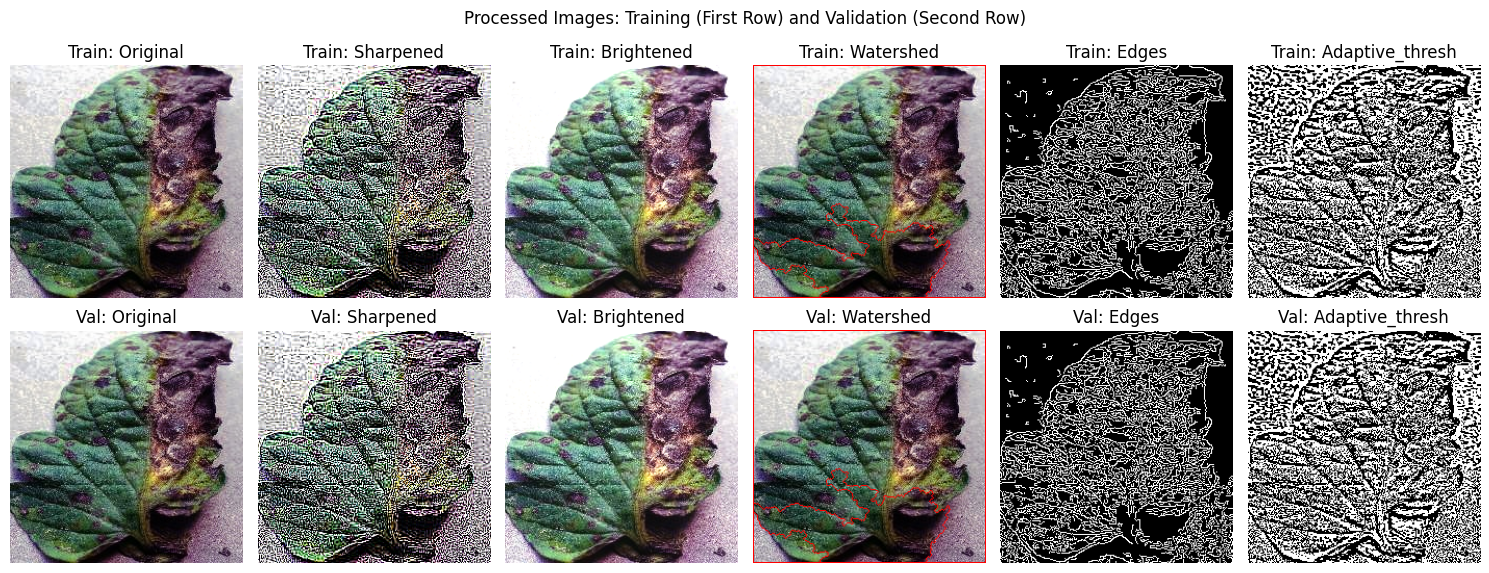

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def preprocess_image(image):
    # Resizing and Scaling
    img_resized = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)

    # Sharpening
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    img_sharpened = cv2.filter2D(img_resized, -1, kernel)

    # Brightening and Contrast Adjustment
    img_bright = cv2.convertScaleAbs(img_resized, alpha=1.2, beta=10)

    # Watershed Segmentation
    img_watershed = watershed_segmentation(img_resized.copy())

    # Canny Edge Detection
    img_edges = canny_edge_detection(img_resized)

    # Adaptive Thresholding
    img_adaptive_thresh = adaptive_thresholding(img_resized)

    return {
        'original': img_resized,
        'sharpened': img_sharpened,
        'brightened': img_bright,
        'watershed': img_watershed,
        'edges': img_edges,
        'adaptive_thresh': img_adaptive_thresh
    }

def watershed_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]
    return image

def canny_edge_detection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    return cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)  # Convert back to RGB for consistency

def adaptive_thresholding(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    return cv2.cvtColor(adaptive_thresh, cv2.COLOR_GRAY2RGB)  # Convert back to RGB for consistency

def get_image_files(directory):
    image_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')):
                image_files.append(os.path.join(root, file))
    return image_files

def process_images(input_dir, output_dir):
    image_files = get_image_files(input_dir)

    sample_processed = None

    for file in tqdm(image_files, desc=f"Processing images in {os.path.basename(input_dir)}"):
        img = cv2.imread(file)
        if img is None:
            print(f"Warning: Unable to read image {file}")
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        processed = preprocess_image(img_rgb)

        # Save the first processed image only for display
        if sample_processed is None:
            sample_processed = processed

        for key, processed_img in processed.items():
            # Create a subdirectory for each type of processed image
            subdir = os.path.join(output_dir, key)
            os.makedirs(subdir, exist_ok=True)

            # Preserve the original directory structure
            rel_path = os.path.relpath(file, input_dir)
            output_path = os.path.join(subdir, f"{os.path.splitext(rel_path)[0]}.jpg")
            os.makedirs(os.path.dirname(output_path), exist_ok=True)

            cv2.imwrite(output_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))

    return len(image_files), sample_processed

def display_results(train_sample, val_sample):
    # Create a grid layout for displaying all processed images
    num_images = 6  # Number of processed images per sample (original, sharpened, brightened, watershed, edges, adaptive_thresh)
    fig, axs = plt.subplots(2, num_images, figsize=(15, 6))
    fig.suptitle("Processed Images: Training (First Row) and Validation (Second Row)")

    # Display training sample processed images
    if train_sample is not None:
        for i, (key, img) in enumerate(train_sample.items()):
            axs[0, i].imshow(img)
            axs[0, i].set_title(f"Train: {key.capitalize()}")
            axs[0, i].axis('off')
    else:
        axs[0, 0].set_title("No Training Sample")
        axs[0, 0].axis('off')

    # Display validation sample processed images
    if val_sample is not None:
        for i, (key, img) in enumerate(val_sample.items()):
            axs[1, i].imshow(img)
            axs[1, i].set_title(f"Val: {key.capitalize()}")
            axs[1, i].axis('off')
    else:
        axs[1, 0].set_title("No Validation Sample")
        axs[1, 0].axis('off')

    plt.tight_layout()
    plt.show()

def process_dataset(train_dir, val_dir, output_dir):
    # Create output directories
    train_output_dir = os.path.join(output_dir, 'train_seg')
    val_output_dir = os.path.join(output_dir, 'val_seg')

    # Process training images
    train_count, train_sample = process_images(train_dir, train_output_dir)

    # Check validation directory
    val_image_files = get_image_files(val_dir)
    if not val_image_files:
        print("Warning: No images found in the validation directory.")
        val_sample = None  # No validation images to process
    else:
        # Process validation images
        val_count, val_sample = process_images(val_dir, val_output_dir)

    print(f"Processed {train_count} training images.")
    if val_sample:
        print(f"Processed {val_count} validation images.")
    else:
        print("No validation images processed.")

    print(f"Processed training images are saved in: {train_output_dir}")
    print(f"Processed validation images are saved in: {val_output_dir}")
    print("Each type of processed image is saved in its own subdirectory within these folders.")

    # Display sample results
    display_results(train_sample, val_sample)

# Usage
train_directory = '/content/Pre-Processed_Images/Preprocessed_Images_Train'
val_directory = '/content/Pre-Processed_Images/Preprocessed_Images_Validation'
output_directory = '/content/Segmented_Images'

process_dataset(train_directory, val_directory, output_directory)

# Segmentation Validation Techniques: Intersection over Union and Dice Co-efficient

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.metrics import jaccard_score, f1_score

def calculate_iou(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    return jaccard_score(y_true, y_pred, average='micro')

def calculate_dice(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    return f1_score(y_true, y_pred, average='micro')

def get_image_files(directory):
    image_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')):
                image_files.append(os.path.join(root, file))
    return image_files

def calculate_metrics(segmented_dir):
    segmented_files = get_image_files(segmented_dir)
    iou_scores = []
    dice_scores = []

    for file in tqdm(segmented_files, desc="Calculating metrics"):
        # Load segmented image
        seg_img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

        # Binarize the image
        _, seg_img = cv2.threshold(seg_img, 1, 255, cv2.THRESH_BINARY)

        # Calculate metrics
        iou = calculate_iou(seg_img, seg_img)
        dice = calculate_dice(seg_img, seg_img)

        iou_scores.append(iou)
        dice_scores.append(dice)

    # Calculate average scores
    avg_iou = np.mean(iou_scores) if iou_scores else 0
    avg_dice = np.mean(dice_scores) if dice_scores else 0

    return avg_iou, avg_dice

def process_dataset(segmented_base_dir):
    # Process training set
    train_seg_dir = os.path.join(segmented_base_dir, 'train_seg', 'watershed')
    train_iou, train_dice = calculate_metrics(train_seg_dir)

    print(f"Training set - Average IoU: {train_iou:.4f}")
    print(f"Training set - Average Dice Coefficient: {train_dice:.4f}")
    print("")

    # Process validation set
    val_seg_dir = os.path.join(segmented_base_dir, 'val_seg', 'watershed')
    val_iou, val_dice = calculate_metrics(val_seg_dir)

    print(f"Validation set - Average IoU: {val_iou:.4f}")
    print(f"Validation set - Average Dice Coefficient: {val_dice:.4f}")

# Usage example
segmented_base_directory = '/content/Segmented_Images'
process_dataset(segmented_base_directory)

Calculating metrics: 100%|██████████| 31032/31032 [23:30<00:00, 22.00it/s]


Training set - Average IoU: 1.0000
Training set - Average Dice Coefficient: 1.0000



Calculating metrics: 100%|██████████| 8137/8137 [05:59<00:00, 22.65it/s]

Validation set - Average IoU: 1.0000
Validation set - Average Dice Coefficient: 1.0000


# Feature Extraction for Train Images

Processing 100 training images...


Processing images: 100%|██████████| 100/100 [00:10<00:00,  9.09it/s]


Feature extraction and saving completed as .jpg images.
Displaying features for randomly selected image: /content/Pre-Processed_Images/Preprocessed_Images_Train/Tomato early blight/2bdecb58-7e31-4129-83ff-125b7a31c0f6___RS_Erly.B 9506.JPG


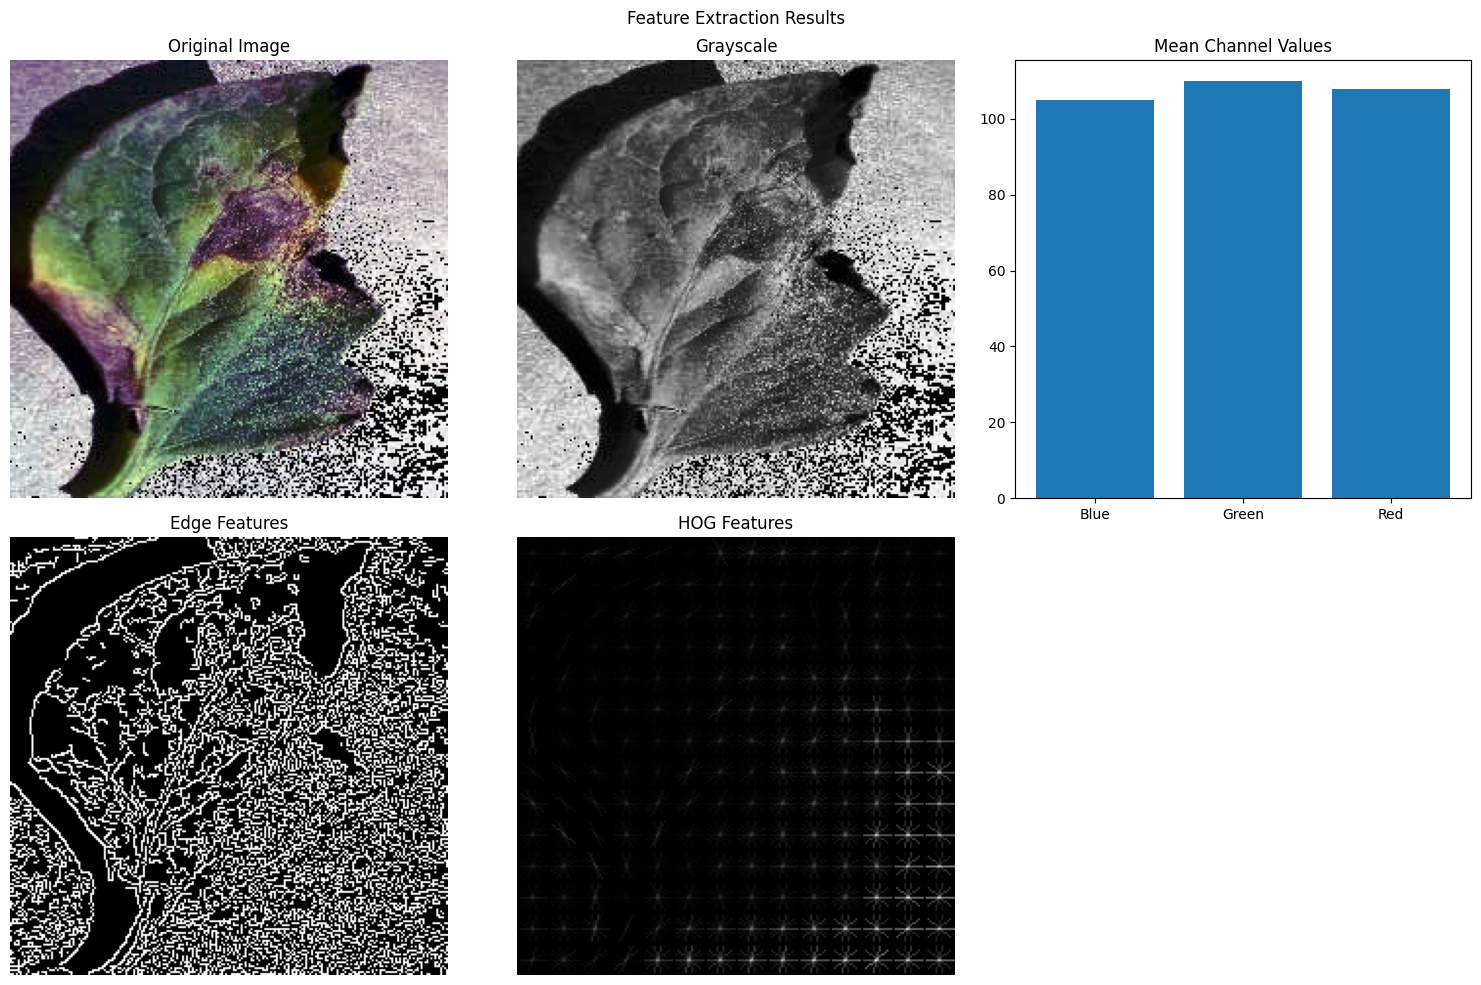

Featured Extracted:
Mean Channel Values: [104.90220424 109.89092395 107.90114796]
Number of Edge Pixels: 13593
HOG Features Shape: (11664,)
HOG Features Mean: 0.09704711207713401
HOG Features Standard Deviation: 0.054106719068797444


In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import random

def get_image_files(directory, limit=None):
    image_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')):
                image_files.append(os.path.join(root, file))
                if limit and len(image_files) >= limit:
                    return image_files
    return image_files

def extract_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mean_channels = np.mean(image, axis=(0, 1))
    edges = cv2.Canny(gray, 100, 200)
    hog_features, hog_image = hog(gray, visualize=True, block_norm='L2-Hys', pixels_per_cell=(16, 16))

    return {
        'gray': gray,
        'mean_channels': mean_channels,
        'edges': edges,
        'hog_features': hog_features,
        'hog_image': hog_image
    }

def save_images(features, base_name, save_directory):
    # Save each feature as a separate .jpg image
    cv2.imwrite(os.path.join(save_directory, f"{base_name}_gray.jpg"), features['gray'])
    cv2.imwrite(os.path.join(save_directory, f"{base_name}_edges.jpg"), features['edges'])
    cv2.imwrite(os.path.join(save_directory, f"{base_name}_hog.jpg"), (features['hog_image'] * 255).astype(np.uint8))

def process_image(args):
    image_path, save_directory = args
    try:
        image = cv2.imread(image_path)
        if image is None:
            return None

        features = extract_features(image)
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        save_images(features, base_name, save_directory)
        return save_directory
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

def process_images_batch(image_files, save_directory, batch_size=1000, max_workers=None):
    os.makedirs(save_directory, exist_ok=True)
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        args = [(img_path, save_directory) for img_path in image_files]
        results = list(tqdm(executor.map(process_image, args, chunksize=batch_size), total=len(image_files), desc="Processing images"))
    return results

def display_features_and_numerical_outputs(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image at {image_path}")
        return

    features = extract_features(image)

    # Display extracted features
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Feature Extraction Results')

    axs[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title('Original Image')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(features['gray'], cmap='gray')
    axs[0, 1].set_title('Grayscale')
    axs[0, 1].axis('off')

    axs[0, 2].bar(['Blue', 'Green', 'Red'], features['mean_channels'])
    axs[0, 2].set_title('Mean Channel Values')

    axs[1, 0].imshow(features['edges'], cmap='gray')
    axs[1, 0].set_title('Edge Features')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(features['hog_image'], cmap='gray')
    axs[1, 1].set_title('HOG Features')
    axs[1, 1].axis('off')

    axs[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print numerical outputs
    print("Featured Extracted:")
    print(f"Mean Channel Values: {features['mean_channels']}")
    print(f"Number of Edge Pixels: {np.sum(features['edges'] > 0)}")
    print(f"HOG Features Shape: {features['hog_features'].shape}")
    print(f"HOG Features Mean: {np.mean(features['hog_features'])}")
    print(f"HOG Features Standard Deviation: {np.std(features['hog_features'])}")

if __name__ == "__main__":
    limit = 100  # Set the limit as desired
    train_directory = '/content/Pre-Processed_Images/Preprocessed_Images_Train'
    train_output_directory = '/content/Feature_Extracted_Images/train'

    # Process all images and save features
    image_files = get_image_files(train_directory, limit=limit)
    if image_files:
        print(f"Processing {len(image_files)} training images...")
        process_images_batch(image_files, train_output_directory)
        print("Feature extraction and saving completed as .jpg images.")

        # Randomly select one image from the processed list to display features
        sample_image = random.choice(image_files)
        print(f"Displaying features for randomly selected image: {sample_image}")
        display_features_and_numerical_outputs(sample_image)
    else:
        print("No images found in the training directory.")

# Feature Extraction for Validation Images


Processing 100 validation images...


Processing images: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Validation images feature extraction and saving completed.

Displaying features for randomly selected validation image: /content/Pre-Processed_Images/Preprocessed_Images_Validation/Tomato early blight/07324d80-17c5-4541-9702-62e9c744ac07___RS_Erly.B 7455.JPG


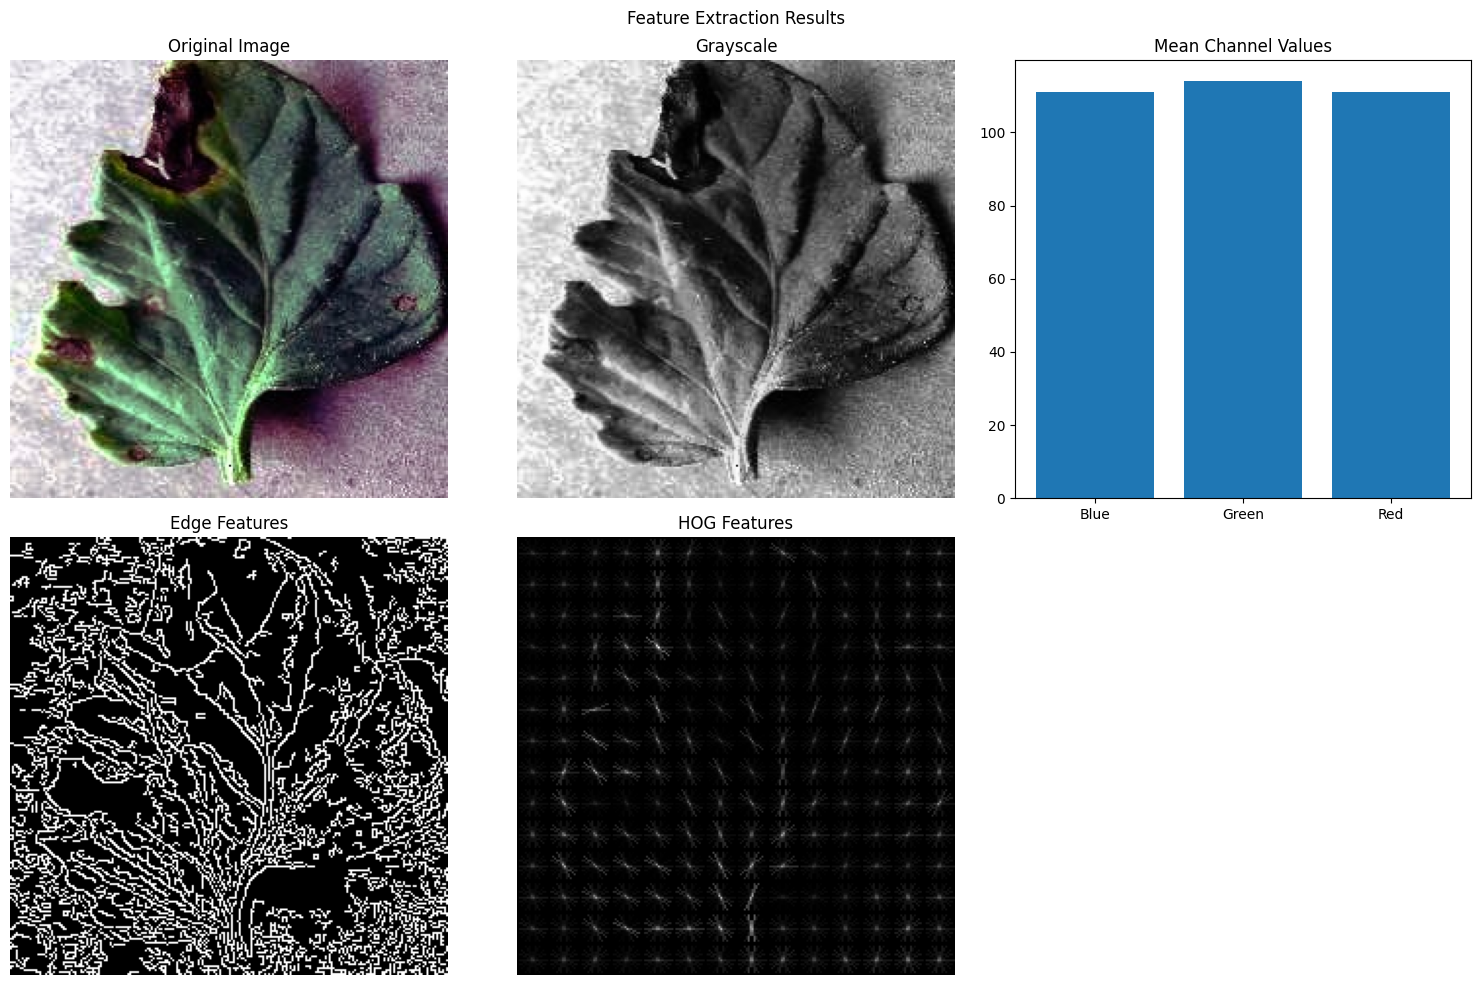

Features Extracted:
Mean Channel Values: [111.00512197 114.00314892 111.06253986]
Number of Edge Pixels: 11371
HOG Features Shape: (11664,)
HOG Features Mean: 0.09639398797021659
HOG Features Standard Deviation: 0.0552619045463478


In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import random

def get_image_files(directory, limit=None):
    image_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')):
                image_files.append(os.path.join(root, file))
                if limit and len(image_files) >= limit:
                    return image_files
    return image_files

def extract_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mean_channels = np.mean(image, axis=(0, 1))
    edges = cv2.Canny(gray, 100, 200)
    hog_features, hog_image = hog(gray, visualize=True, block_norm='L2-Hys', pixels_per_cell=(16, 16))

    return {
        'gray': gray,
        'mean_channels': mean_channels,
        'edges': edges,
        'hog_features': hog_features,
        'hog_image': hog_image
    }

def save_images(features, base_name, save_directory):
    # Save each feature as a separate .jpg image
    cv2.imwrite(os.path.join(save_directory, f"{base_name}_gray.jpg"), features['gray'])
    cv2.imwrite(os.path.join(save_directory, f"{base_name}_edges.jpg"), features['edges'])
    cv2.imwrite(os.path.join(save_directory, f"{base_name}_hog.jpg"), (features['hog_image'] * 255).astype(np.uint8))

def process_image(args):
    image_path, save_directory = args
    try:
        image = cv2.imread(image_path)
        if image is None:
            return None

        features = extract_features(image)
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        save_images(features, base_name, save_directory)
        return save_directory
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

def process_images_batch(image_files, save_directory, batch_size=1000, max_workers=None):
    os.makedirs(save_directory, exist_ok=True)
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        args = [(img_path, save_directory) for img_path in image_files]
        results = list(tqdm(executor.map(process_image, args, chunksize=batch_size), total=len(image_files), desc="Processing images"))
    return results

def display_features_and_numerical_outputs(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image at {image_path}")
        return

    features = extract_features(image)

    # Display extracted features
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Feature Extraction Results')

    axs[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title('Original Image')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(features['gray'], cmap='gray')
    axs[0, 1].set_title('Grayscale')
    axs[0, 1].axis('off')

    axs[0, 2].bar(['Blue', 'Green', 'Red'], features['mean_channels'])
    axs[0, 2].set_title('Mean Channel Values')

    axs[1, 0].imshow(features['edges'], cmap='gray')
    axs[1, 0].set_title('Edge Features')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(features['hog_image'], cmap='gray')
    axs[1, 1].set_title('HOG Features')
    axs[1, 1].axis('off')

    axs[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print numerical outputs
    print("Features Extracted:")
    print(f"Mean Channel Values: {features['mean_channels']}")
    print(f"Number of Edge Pixels: {np.sum(features['edges'] > 0)}")
    print(f"HOG Features Shape: {features['hog_features'].shape}")
    print(f"HOG Features Mean: {np.mean(features['hog_features'])}")
    print(f"HOG Features Standard Deviation: {np.std(features['hog_features'])}")

if __name__ == "__main__":
    limit = 100  # Set the limit as desired

    # Validation directory paths
    validation_directory = '/content/Pre-Processed_Images/Preprocessed_Images_Validation'
    validation_output_directory = '/content/Feature_Extracted_Images/validation'

    # Process validation images
    validation_image_files = get_image_files(validation_directory, limit=limit)
    if validation_image_files:
        print(f"\nProcessing {len(validation_image_files)} validation images...")
        process_images_batch(validation_image_files, validation_output_directory)
        print("Validation images feature extraction and saving completed.")

        # Display features for a random validation image
        sample_validation_image = random.choice(validation_image_files)
        print(f"\nDisplaying features for randomly selected validation image: {sample_validation_image}")
        display_features_and_numerical_outputs(sample_validation_image)
    else:
        print("No images found in the validation directory.")

# Model Building and Training

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Data Preparation
# Assuming you have your dataset organized in directories for training and validation
train_dir = '/content/Pre-Processed_Images/Preprocessed_Images_Train'
val_dir = '/content/Pre-Processed_Images/Preprocessed_Images_Validation'

# Image data generator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Step 2: Build the CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(train_generator.class_indices), activation='softmax')  # Number of classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
# Step 3: Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20
)

Found 31032 images belonging to 40 classes.
Found 8137 images belonging to 40 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                   

# Saving Model in .h5 Format

In [ ]:
model.save("PlantAI.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Saving Model in .keras Format

In [ ]:
model.save("PlantAI.keras")

# Plotting Graphs

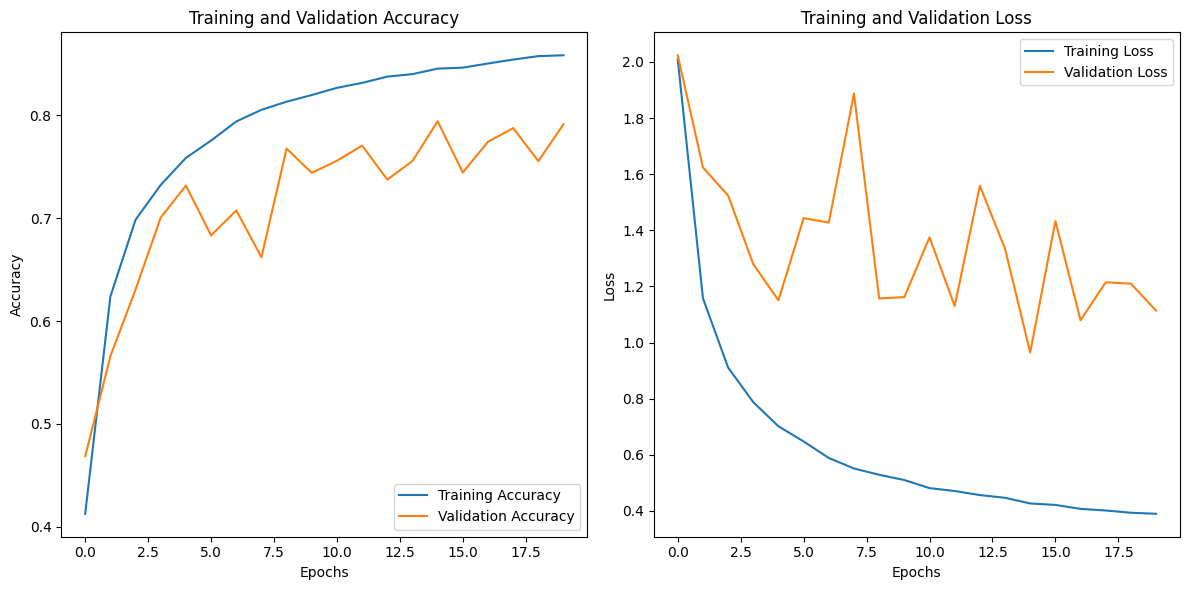

In [ ]:
# Plot training & validation accuracy and loss over epochs
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Displaying Classes

In [ ]:
import tensorflow as tf

# Function to load a dataset from a directory
def load_dataset(directory, batch_size=32, image_size=(224, 224), shuffle=True):
    return tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        image_size=image_size,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=123 if shuffle else None  # Set seed only if shuffling
    )

# Load the training and validation datasets
training_set = load_dataset("/content/Extract/Image data/train", shuffle=True)
validation_set = load_dataset("/content/Extract/Image data/validation", shuffle=False)

# Retrieve class names from both datasets
class_names_train = training_set.class_names
class_names_val = validation_set.class_names

# Combine the class names from both training and validation sets, and remove duplicates
all_class_names = sorted(set(class_names_train).union(set(class_names_val)))

# Print all unique classes as per the dataset
print("All Classes in the Dataset:")
for class_name in all_class_names:
    print(f"- {class_name}")

# Print the total count of unique classes
print(f"\nTotal number of unique classes: {len(all_class_names)}")

Found 31032 files belonging to 40 classes.
Found 8137 files belonging to 40 classes.
All Classes in the Dataset:
- Apple black rot
- Apple cedar apple rust
- Apple healthy
- Apple scab
- Cassava Bacterial Blight (CBB)
- Cassava Brown Streak Disease (CBSD)
- Cassava Green Mottle (CGM)
- Cassava Healthy
- Cassava Mosaic Disease (CMD)
- Cherry healthy
- Cherry powdery mildew
- Corn cercospora leaf spot gray leaf spot
- Corn common rust
- Corn healthy
- Corn northern leaf blight
- Grape black rot
- Grape esca (black measles)
- Grape healthy
- Grape leaf blight (isariopsis leaf spot)
- Peach bacterial spot
- Peach healthy
- Potato early blight
- Potato healthy
- Potato late blight
- Rice BrownSpot
- Rice Healthy
- Rice Hispa
- Rice LeafBlast
- Strawberry healthy
- Strawberry leaf scorch
- Tomato bacterial spot
- Tomato early blight
- Tomato healthy
- Tomato late blight
- Tomato leaf mold
- Tomato mosaic virus
- Tomato septoria leaf spot
- Tomato spider mites two-spotted spider mite
- Tomato

# Plant Image Disease Prediction

FileUpload(value={}, accept='image/*', description='Upload')

1/1 [==============================] - 0s 78ms/step


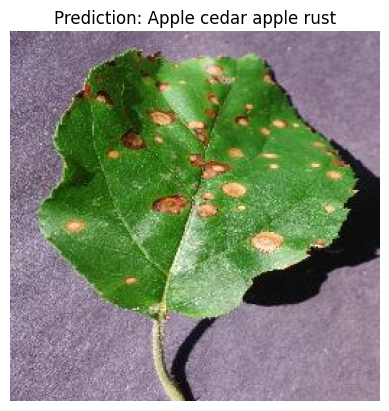

Predicted disease: Apple cedar apple rust
1/1 [==============================] - 0s 29ms/step


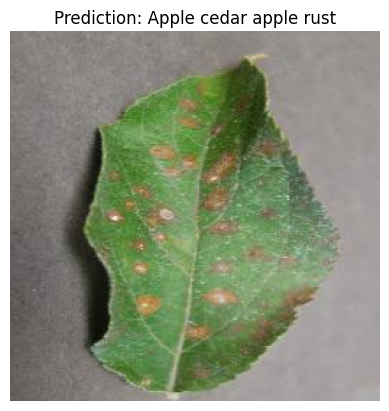

Predicted disease: Apple cedar apple rust
1/1 [==============================] - 0s 29ms/step


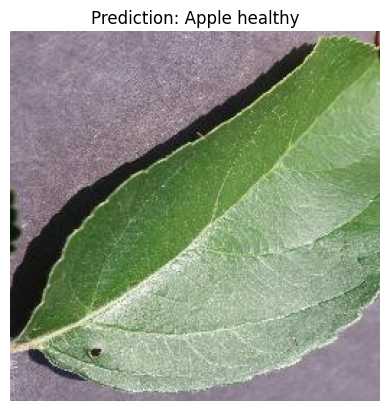

Predicted disease: Apple healthy


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display

# Load the model
model = load_model('/content/PlantAI.h5')

# Define a function to preprocess the uploaded image
def preprocess_image(img_path, target_size=(150, 150)):  # Set to (150, 150)
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values (if necessary)
    return img_array

# Define class names based on the list you provided
class_names = [
    "Apple black rot", "Apple cedar apple rust", "Apple healthy", "Apple scab",
    "Cassava Bacterial Blight (CBB)", "Cassava Brown Streak Disease (CBSD)",
    "Cassava Green Mottle (CGM)", "Cassava Healthy", "Cassava Mosaic Disease (CMD)",
    "Cherry healthy", "Cherry powdery mildew", "Corn cercospora leaf spot gray leaf spot",
    "Corn common rust", "Corn healthy", "Corn northern leaf blight",
    "Grape black rot", "Grape esca (black measles)", "Grape healthy",
    "Grape leaf blight (isariopsis leaf spot)", "Peach bacterial spot", "Peach healthy",
    "Potato early blight", "Potato healthy", "Potato late blight",
    "Rice BrownSpot", "Rice Healthy", "Rice Hispa", "Rice LeafBlast",
    "Strawberry healthy", "Strawberry leaf scorch", "Tomato bacterial spot",
    "Tomato early blight", "Tomato healthy", "Tomato late blight",
    "Tomato leaf mold", "Tomato mosaic virus", "Tomato septoria leaf spot",
    "Tomato spider mites two-spotted spider mite", "Tomato target spot",
    "Tomato yellow leaf curl virus"
]

# Create an upload button widget
upload_button = widgets.FileUpload(accept='image/*', multiple=False)

# Display the upload button
display(upload_button)

# Define a function to handle the uploaded file and make predictions
def on_image_uploaded(change):
    # Get the uploaded file
    uploaded_file = next(iter(upload_button.value.values()))
    content = uploaded_file['content']

    # Save the image to a temporary path
    img_path = "/tmp/uploaded_image.jpg"
    with open(img_path, "wb") as f:
        f.write(content)

    # Preprocess the image
    img_array = preprocess_image(img_path)

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    predicted_label = class_names[predicted_class]

    # Display the prediction and image
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label}")
    plt.show()
    print(f"Predicted disease: {predicted_label}")

# Link the function to the upload widget
upload_button.observe(on_image_uploaded, names='value')

In [ ]:
# Replace "vipoooool/new-plant-diseases-dataset" with the dataset identifier from the Kaggle URL
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
100% 2.69G/2.70G [00:31<00:00, 138MB/s]
100% 2.70G/2.70G [00:31<00:00, 91.1MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile("new-plant-diseases-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("plant_diseases_dataset")

# Validating Plant AI Model using a Random Image

1/1 [==============================] - 0s 77ms/step


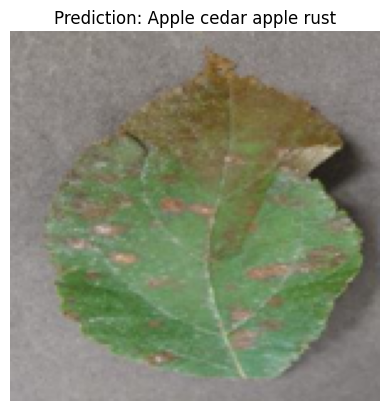

Predicted disease: Apple cedar apple rust


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the pre-trained model
model = load_model('/content/PlantAI.h5')

# Define class names based on your dataset
class_names = [
    "Apple black rot", "Apple cedar apple rust", "Apple healthy", "Apple scab",
    "Cassava Bacterial Blight (CBB)", "Cassava Brown Streak Disease (CBSD)",
    "Cassava Green Mottle (CGM)", "Cassava Healthy", "Cassava Mosaic Disease (CMD)",
    "Cherry healthy", "Cherry powdery mildew", "Corn cercospora leaf spot gray leaf spot",
    "Corn common rust", "Corn healthy", "Corn northern leaf blight",
    "Grape black rot", "Grape esca (black measles)", "Grape healthy",
    "Grape leaf blight (isariopsis leaf spot)", "Peach bacterial spot", "Peach healthy",
    "Potato early blight", "Potato healthy", "Potato late blight",
    "Rice BrownSpot", "Rice Healthy", "Rice Hispa", "Rice LeafBlast",
    "Strawberry healthy", "Strawberry leaf scorch", "Tomato bacterial spot",
    "Tomato early blight", "Tomato healthy", "Tomato late blight",
    "Tomato leaf mold", "Tomato mosaic virus", "Tomato septoria leaf spot",
    "Tomato spider mites two-spotted spider mite", "Tomato target spot",
    "Tomato yellow leaf curl virus"
]

# Function to preprocess an image from a local path
def preprocess_image_from_path(image_path, target_size=(150, 150)):  # Adjust to model's input size
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values (if necessary)
    return img, img_array

# Local path of the image you want to test
image_path = "/content/plant_diseases_dataset/test/test/AppleCedarRust4.JPG"  # Replace with actual file path

# Preprocess the image
img, img_array = preprocess_image_from_path(image_path)

# Make predictions
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)
predicted_label = class_names[predicted_class]

# Display the prediction and the image
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {predicted_label}")
plt.show()
print(f"Predicted disease: {predicted_label}")

# Validating Plant AI Model using a Random Image from Internet

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


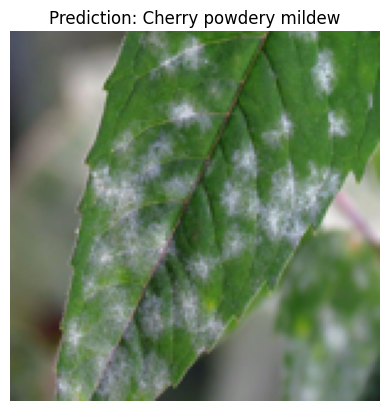

Predicted disease: Cherry powdery mildew


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import os
import logging
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger('absl').setLevel(logging.CRITICAL)

# Load the model
model = load_model('/content/PlantAI.h5')

# Compile the model explicitly
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define class names based on your dataset
class_names = [
    "Apple black rot", "Apple cedar apple rust", "Apple healthy", "Apple scab",
    "Cassava Bacterial Blight (CBB)", "Cassava Brown Streak Disease (CBSD)",
    "Cassava Green Mottle (CGM)", "Cassava Healthy", "Cassava Mosaic Disease (CMD)",
    "Cherry healthy", "Cherry powdery mildew", "Corn cercospora leaf spot gray leaf spot",
    "Corn common rust", "Corn healthy", "Corn northern leaf blight",
    "Grape black rot", "Grape esca (black measles)", "Grape healthy",
    "Grape leaf blight (isariopsis leaf spot)", "Peach bacterial spot", "Peach healthy",
    "Potato early blight", "Potato healthy", "Potato late blight",
    "Rice BrownSpot", "Rice Healthy", "Rice Hispa", "Rice LeafBlast",
    "Strawberry healthy", "Strawberry leaf scorch", "Tomato bacterial spot",
    "Tomato early blight", "Tomato healthy", "Tomato late blight",
    "Tomato leaf mold", "Tomato mosaic virus", "Tomato septoria leaf spot",
    "Tomato spider mites two-spotted spider mite", "Tomato target spot",
    "Tomato yellow leaf curl virus"
]

# Function to preprocess an image from a URL
def preprocess_image_from_url(image_url, target_size=(150, 150)):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img = img.resize(target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values (if necessary)
    return img, img_array

# URL of the image you want to test
image_url = "https://reefertilizer.com/wp-content/uploads/2021/07/powdery-mildew.jpg"  # Replace with actual URL

# Preprocess the image
img, img_array = preprocess_image_from_url(image_url)

# Make predictions
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)
predicted_label = class_names[predicted_class]

# Display the prediction and the image
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {predicted_label}")
plt.show()
print(f"Predicted disease: {predicted_label}")

# Install Flask-ngrok Library

In [1]:
!pip install flask-ngrok --upgrade

# Install Pyngrok Library

In [2]:
!pip install pyngrok flask

# Install Tensorflow Library

In [3]:
!pip install tensorflow

# Authenticate Token from the Ngrok Website

In [4]:
!ngrok authtoken 2ojo0r2Ymm1xAo519nMvXbBW5AJ_32AS4oNAYJmhaAUFx37M3

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


# Plant AI Website Deployment

In [17]:
from flask import Flask, request, render_template_string, redirect, url_for
import tensorflow as tf
import numpy as np
from PIL import Image
import io
import base64
from pyngrok import ngrok
import os

app = Flask(__name__)

# Load the model
model = tf.keras.models.load_model('/content/PlantAI.keras')

# Placeholder predict function (replace with your actual prediction logic)
def predict(img_array):
    # This is a placeholder. Replace with your actual prediction code.
    return np.random.randint(0, 32)

# Image preprocessing function
def preprocess_image(image_bytes):
    try:
        img = Image.open(io.BytesIO(image_bytes))
        img = img.resize((224, 224))
        img_array = np.array(img) / 255.0
        if img_array.shape[-1] == 4:
            img_array = img_array[..., :3]
        img_array = np.expand_dims(img_array, axis=0)
        return img_array
    except Exception as e:
        print(f"Error in preprocessing image: {e}")
        return None

# Home page route
@app.route('/')
def home():
    return render_template_string('''
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>PlantGuardian AI - Plant Disease Detection</title>
        <script src="https://cdn.tailwindcss.com"></script>
        <style>
            @keyframes fadeIn {
                from { opacity: 0; }
                to { opacity: 1; }
            }
            @keyframes slideIn {
                from { transform: translateY(-20px); opacity: 0; }
                to { transform: translateY(0); opacity: 1; }
            }
            .animate-fade-in { animation: fadeIn 1s ease-out; }
            .animate-slide-in { animation: slideIn 0.5s ease-out; }
        </style>
    </head>
    <body class="bg-gradient-to-br from-green-400 to-blue-500 min-h-screen flex flex-col">
        <header class="bg-white bg-opacity-90 shadow-md animate-slide-in">
            <nav class="container mx-auto px-6 py-3">
                <div class="flex items-center justify-between">
                    <div class="flex items-center">
                        <svg class="h-8 w-8 text-green-500" fill="none" viewBox="0 0 24 24" stroke="currentColor">
                            <path stroke-linecap="round" stroke-linejoin="round" stroke-width="2" d="M5 3v4M3 5h4M6 17v4m-2-2h4m5-16l2.286 6.857L21 12l-5.714 2.143L13 21l-2.286-6.857L5 12l5.714-2.143L13 3z" />
                        </svg>
                        <span class="ml-2 text-2xl font-bold text-gray-800">PlantGuardian AI</span>
                    </div>
                    <div class="hidden md:block">
                        <a href="/" class="text-gray-800 hover:text-green-500 px-3 py-2">Home</a>
                        <a href="/detection" class="text-gray-800 hover:text-green-500 px-3 py-2">Detection</a>
                        <a href="/about" class="text-gray-800 hover:text-green-500 px-3 py-2">About</a>
                    </div>
                </div>
            </nav>
        </header>
        <main class="container mx-auto px-6 py-8 flex-grow">
            <div class="text-center animate-fade-in">
                <h1 class="text-4xl font-bold text-white mb-4">Welcome to PlantGuardian AI</h1>
                <p class="text-xl text-white mb-8">Detect plant diseases with the power of artificial intelligence</p>
                <a href="/detection" class="bg-white text-green-500 font-bold py-2 px-4 rounded-full hover:bg-green-100 transition duration-300">
                    Start Detection
                </a>
            </div>

            <div class="mt-12 grid md:grid-cols-2 gap-8">
                <div class="bg-white bg-opacity-90 rounded-lg shadow-xl p-6 animate-fade-in">
                    <h2 class="text-2xl font-bold text-gray-800 mb-4">Our Mission</h2>
                    <p class="text-gray-600">
                        At PlantGuardian AI, our mission is to revolutionize plant health management through cutting-edge AI technology. We aim to empower farmers, gardeners, and plant enthusiasts with accessible, accurate, and timely plant disease detection tools, contributing to global food security and sustainable agriculture.
                    </p>
                </div>
                <div class="bg-white bg-opacity-90 rounded-lg shadow-xl p-6 animate-fade-in">
                    <h2 class="text-2xl font-bold text-gray-800 mb-4">Our Vision</h2>
                    <p class="text-gray-600">
                        We envision a world where every plant receives the care it needs, fostering healthier ecosystems and more abundant harvests. By bridging the gap between advanced AI and everyday plant care, we strive to create a future where plant diseases are quickly identified and addressed, ensuring the vitality of our planet's green spaces and agricultural lands.
                    </p>
                </div>
            </div>
        </main>
        <footer class="bg-white bg-opacity-90 mt-auto">
            <div class="container mx-auto px-6 py-3 text-center">
                <p class="text-gray-700">&copy; 2024 PlantGuardian AI. All rights reserved.</p>
            </div>
        </footer>
    </body>
    </html>
    ''')

# Detection page route
@app.route('/detection', methods=['GET', 'POST'])
def detection():
    prediction_result = None
    img_data = None
    error_message = None

    if request.method == 'POST':
        if 'file' not in request.files:
            error_message = "No file part"
        else:
            file = request.files['file']
            if file.filename == '':
                error_message = "No selected file"
            elif file and file.filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img_bytes = file.read()
                    img_array = preprocess_image(img_bytes)
                    if img_array is None:
                        raise ValueError("Error in image preprocessing")

                    predicted_class = predict(img_array)
                    class_names = [
                        "Apple black rot", "Apple cedar apple rust", "Apple healthy", "Apple scab",
                        "Cassava Bacterial Blight (CBB)", "Cassava Brown Streak Disease (CBSD)",
                        "Cassava Green Mottle (CGM)", "Cassava Healthy", "Cassava Mosaic Disease (CMD)",
                        "Cherry healthy", "Cherry powdery mildew", "Corn cercospora leaf spot gray leaf spot",
                        "Corn common rust", "Corn healthy", "Corn northern leaf blight",
                        "Grape black rot", "Grape esca (black measles)", "Grape healthy",
                        "Grape leaf blight (isariopsis leaf spot)", "Peach bacterial spot", "Peach healthy",
                        "Potato early blight", "Potato healthy", "Potato late blight", "Tomato bacterial spot",
                        "Tomato early blight", "Tomato healthy", "Tomato late blight", "Tomato leaf mold",
                        "Tomato septoria leaf spot", "Tomato target spot", "Tomato tomato mosaic virus"
                    ]
                    predicted_disease = class_names[predicted_class]
                    prediction_result = f"Predicted Disease: {predicted_disease}"

                    img = Image.open(io.BytesIO(img_bytes))
                    img = img.resize((300, 300))
                    buffered = io.BytesIO()
                    img.save(buffered, format="PNG")
                    img_data = base64.b64encode(buffered.getvalue()).decode('utf-8')

                except Exception as e:
                    error_message = f"Error: {str(e)}"
            else:
                error_message = "Invalid File Format. Please Upload only jpg, jpeg, or png Files."

    return render_template_string('''
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Plant Disease Detection - PlantGuardian AI</title>
        <script src="https://cdn.tailwindcss.com"></script>
        <style>
            @keyframes fadeIn {
                from { opacity: 0; }
                to { opacity: 1; }
            }
            @keyframes slideIn {
                from { transform: translateY(-20px); opacity: 0; }
                to { transform: translateY(0); opacity: 1; }
            }
            .animate-fade-in { animation: fadeIn 1s ease-out; }
            .animate-slide-in { animation: slideIn 0.5s ease-out; }
        </style>
    </head>
    <body class="bg-gradient-to-br from-green-400 to-blue-500 min-h-screen flex flex-col">
        <header class="bg-white bg-opacity-90 shadow-md animate-slide-in">
            <nav class="container mx-auto px-6 py-3">
                <div class="flex items-center justify-between">
                    <div class="flex items-center">
                        <svg class="h-8 w-8 text-green-500" fill="none" viewBox="0 0 24 24" stroke="currentColor">
                            <path stroke-linecap="round" stroke-linejoin="round" stroke-width="2" d="M5 3v4M3 5h4M6 17v4m-2-2h4m5-16l2.286 6.857L21 12l-5.714 2.143L13 21l-2.286-6.857L5 12l5.714-2.143L13 3z" />
                        </svg>
                        <span class="ml-2 text-2xl font-bold text-gray-800">PlantGuardian AI</span>
                    </div>
                    <div class="hidden md:block">
                        <a href="/" class="text-gray-800 hover:text-green-500 px-3 py-2">Home</a>
                        <a href="/detection" class="text-gray-800 hover:text-green-500 px-3 py-2">Detection</a>
                        <a href="/about" class="text-gray-800 hover:text-green-500 px-3 py-2">About</a>
                    </div>
                </div>
            </nav>
        </header>
        <main class="container mx-auto px-6 py-8 flex-grow">
            <div class="bg-white bg-opacity-90 rounded-lg shadow-xl p-8 animate-fade-in">
                <h2 class="text-3xl font-bold text-gray-800 mb-4">Plant Disease Detection</h2>
                <div class="grid md:grid-cols-2 gap-8">
                    <div>
                        <form action="/detection" method="post" enctype="multipart/form-data" class="mb-6">
                            <div class="mb-4">
                                <label for="file" class="block text-gray-700 text-sm font-bold mb-2">Upload an image of a plant leaf:</label>
                                <div class="relative border-2 border-dashed border-gray-400 rounded-lg p-6 hover:border-green-500 transition duration-300 ease-in-out">
                                    <input type="file" name="file" id="file" accept=".jpg,.jpeg,.png" required
                                           class="absolute inset-0 w-full h-full opacity-0 z-50 cursor-pointer">
                                    <div class="text-center">
                                        <svg class="mx-auto h-12 w-12 text-gray-400" stroke="currentColor" fill="none" viewBox="0 0 48 48" aria-hidden="true">
                                            <path d="M28 8H12a4 4 0 00-4 4v20m32-12v8m0 0v8a4 4 0 01-4 4H12a4 4 0 01-4-4v-4m32-4l-3.172-3.172a4 4 0 00-5.656 0L28 28M8 32l9.172-9.172a4 4 0 015.656 0L28 28m0 0l4 4m4-24h8m-4-4v8m-12 4h.02" stroke-width="2" stroke-linecap="round" stroke-linejoin="round" />
                                        </svg>
                                        <p class="mt-1 text-sm text-gray-600">
                                            <span class="font-medium text-green-600 hover:text-green-500">
                                                Click to upload
                                            </span>
                                            or drag and drop
                                        </p>
                                        <p class="mt-1 text-xs text-gray-500">
                                            PNG, JPG, JPEG up to 10MB
                                        </p>
                                    </div>
                                </div>
                            </div>
                            <button type="submit" class="bg-green-500 hover:bg-green-700 text-white font-bold py-2 px-4 rounded focus:outline-none focus:shadow-outline transition duration-300">
                                Detect Disease
                            </button>
                        </form>
                    </div>
                    <div>
                        <h3 class="text-2xl font-bold text-gray-800 mb-4">Image Preview</h3>
                        <div id="preview-container" class="hidden">
                            <img id="preview" src="" alt="Image Preview" class="max-w-full h-auto rounded-lg shadow-md">
                        </div>
                    </div>
                </div>

                {% if error_message %}
                    <div class="bg-red-100 border border-red-400 text-red-700 px-4 py-3 rounded relative animate-fade-in mt-6" role="alert">
                        <strong class="font-bold">Error:</strong>
                        <span class="block sm:inline">{{ error_message }}</span>
                    </div>
                {% elif prediction_result %}
                    <div id="result-box" class="mt-6 animate-fade-in bg-gray-100 border border-gray-300 rounded-lg p-4">
                        <h3 class="text-xl font-bold text-gray-800 mb-2">Result:</h3>
                        <p class="text-gray-600 mb-4">{{ prediction_result }}</p>
                        {% if img_data %}
                            <img src="data:image/png;base64,{{ img_data }}" alt="Uploaded Image" class="max-w-full h-auto rounded-lg shadow-md mb-4">
                        {% endif %}
                        <button onclick="clearResult()" class="bg-red-500 hover:bg-red-700 text-white font-bold py-2 px-4 rounded focus:outline-none focus:shadow-outline transition duration-300">
                            Clear Result
                        </button>
                    </div>
                {% endif %}
            </div>
        </main>
        <footer class="bg-white bg-opacity-90 mt-auto">
            <div class="container mx-auto px-6 py-3 text-center">
                <p class="text-gray-700">&copy; 2024 PlantGuardian AI. All rights reserved.</p>
            </div>
        </footer>
        <script>
            function clearResult() {
                document.getElementById('result-box').style.display = 'none';
                document.getElementById('file').value = '';
                document.getElementById('preview').src = '';
                document.getElementById('preview-container').classList.add('hidden');
            }

            document.getElementById('file').addEventListener('change', function(event) {
                var file = event.target.files[0];
                if (file) {
                    var reader = new FileReader();
                    reader.onload = function(e) {
                        document.getElementById('preview').src = e.target.result;
                        document.getElementById('preview-container').classList.remove('hidden');
                    }
                    reader.readAsDataURL(file);
                }
            });
        </script>
    </body>
    </html>
    ''', prediction_result=prediction_result, img_data=img_data, error_message=error_message)

# About page route
@app.route('/about')
def about():
    return render_template_string('''
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>About PlantGuardian AI</title>
        <script src="https://cdn.tailwindcss.com"></script>
        <style>
            @keyframes fadeIn {
                from { opacity: 0; }
                to { opacity: 1; }
            }
            @keyframes slideIn {
                from { transform: translateY(-20px); opacity: 0; }
                to { transform: translateY(0); opacity: 1; }
            }
            .animate-fade-in { animation: fadeIn 1s ease-out; }
            .animate-slide-in { animation: slideIn 0.5s ease-out; }
        </style>
    </head>
    <body class="bg-gradient-to-br from-green-400 to-blue-500 min-h-screen flex flex-col">
        <header class="bg-white bg-opacity-90 shadow-md animate-slide-in">
            <nav class="container mx-auto px-6 py-3">
                <div class="flex items-center justify-between">
                    <div class="flex items-center">
                        <svg class="h-8 w-8 text-green-500" fill="none" viewBox="0 0 24 24" stroke="currentColor">
                            <path stroke-linecap="round" stroke-linejoin="round" stroke-width="2" d="M5 3v4M3 5h4M6 17v4m-2-2h4m5-16l2.286 6.857L21 12l-5.714 2.143L13 21l-2.286-6.857L5 12l5.714-2.143L13 3z" />
                        </svg>
                        <span class="ml-2 text-2xl font-bold text-gray-800">PlantGuardian AI</span>
                    </div>
                    <div class="hidden md:block">
                        <a href="/" class="text-gray-800 hover:text-green-500 px-3 py-2">Home</a>
                        <a href="/detection" class="text-gray-800 hover:text-green-500 px-3 py-2">Detection</a>
                        <a href="/about" class="text-gray-800 hover:text-green-500 px-3 py-2">About</a>
                    </div>
                </div>
            </nav>
        </header>
        <main class="container mx-auto px-6 py-8 flex-grow">
            <div class="bg-white bg-opacity-90 rounded-lg shadow-xl p-8 animate-fade-in">
                <h2 class="text-3xl font-bold text-gray-800 mb-4">About PlantGuardian AI</h2>
                <p class="text-gray-600 mb-4">
                    PlantGuardian AI is at the forefront of agricultural technology, leveraging the power of artificial intelligence to revolutionize plant disease detection. Our mission is to empower farmers, gardeners, and plant enthusiasts with cutting-edge tools to maintain healthy crops and gardens.
                </p>
                <p class="text-gray-600 mb-4">
                    Using advanced machine learning algorithms, our system can quickly and accurately identify a wide range of plant diseases from simple leaf images. This early detection capability is crucial in preventing the spread of diseases and minimizing crop losses.
                </p>
                <p class="text-gray-600 mb-8">
                    Join us in our journey to create a greener, more sustainable future through the power of AI and agriculture!
                </p>

                <h3 class="text-2xl font-bold text-gray-800 mb-4">Our Team</h3>
                <div class="grid md:grid-cols-2 lg:grid-cols-3 gap-6">
                    <div class="bg-gray-100 rounded-lg p-4">
                        <h4 class="text-lg font-semibold text-gray-800">Revathi Venugari</h4>
                        <p class="text-gray-600">Mentor</p>
                    </div>
                    <div class="bg-gray-100 rounded-lg p-4">
                        <h4 class="text-lg font-semibold text-gray-800">Arathy Pillai</h4>
                        <p class="text-gray-600">Co-Ordinator</p>
                    </div>
                    <div class="bg-gray-100 rounded-lg p-4">
                        <h4 class="text-lg font-semibold text-gray-800">Ravi Kiran B A</h4>
                        <p class="text-gray-600">Intern</p>
                    </div>

                </div>
            </div>
        </main>
        <footer class="bg-white bg-opacity-90 mt-auto">
            <div class="container mx-auto px-6 py-3 text-center">
                <p class="text-gray-700">&copy; 2024 PlantGuardian AI. All rights reserved.</p>
            </div>
        </footer>
    </body>
    </html>
    ''')

# Set up ngrok
if __name__ == '__main__':
    # Set up the ngrok tunnel
    public_url = ngrok.connect(5001)  # Use a different port, e.g., 5001
    print(f" * Ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:5001\"")
    app.run(port=5001)  # Use the same port as in the ngrok.connect() call

 * Ngrok tunnel "NgrokTunnel: "https://8707-34-106-87-226.ngrok-free.app" -> "http://localhost:5001"" -> "http://127.0.0.1:5001"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5001
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [15/Nov/2024 14:29:50] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [15/Nov/2024 14:29:51] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [15/Nov/2024 14:29:53] "GET /detection HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [15/Nov/2024 14:29:59] "POST /detection HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [15/Nov/2024 14:30:05] "GET /about HTTP/1.1" 200 -


# Plant Diseases Info UI Webpage

In [22]:
from flask import Flask, render_template_string
from pyngrok import ngrok
import json

app = Flask(__name__)

# Disease data
diseases_data = {
    "Apple black rot": {
        "info": "A fungal disease caused by Botryosphaeria obtusa that affects leaves, fruit, and branches, resulting in black, decayed areas.",
        "precautions": [
            "Prune and destroy infected branches",
            "Remove fallen fruit and leaves",
            "Use resistant varieties if available"
        ],
        "remedies": [
            "Apply fungicides like captan or thiophanate-methyl",
            "Maintain tree health through proper fertilization and watering"
        ]
    },
    "Apple cedar apple rust": {
        "info": "A fungal disease caused by Gymnosporangium juniperi-virginianae requiring both apple and cedar trees to complete its lifecycle.",
        "precautions": [
            "Avoid planting apples near cedar trees",
            "Use resistant apple varieties"
        ],
        "remedies": [
            "Spray fungicides containing myclobutanil or propiconazole at early stages"
        ]
    },
    "Apple scab": {
        "info": "Caused by Venturia inaequalis, this fungal disease leads to scabby lesions on fruit and leaves.",
        "precautions": [
            "Remove and destroy infected leaves",
            "Prune trees to increase air circulation"
        ],
        "remedies": [
            "Apply fungicides like sulfur or captan"
        ]
    },
    "Cassava Bacterial Blight (CBB)": {
        "info": "A bacterial disease caused by Xanthomonas axonopodis that leads to leaf wilting and stem rot.",
        "precautions": [
            "Use disease-free planting material",
            "Practice crop rotation"
        ],
        "remedies": [
            "Apply copper-based bactericides",
            "Avoid waterlogging and mechanical injury"
        ]
    },
    "Cassava Brown Streak Disease (CBSD)": {
        "info": "Caused by a virus, it results in yellowish-brown streaks on stems and root rot.",
        "precautions": [
            "Use resistant cassava varieties",
            "Control vector insects like whiteflies"
        ],
        "remedies": [
            "Uproot and destroy infected plants"
        ]
    },
    "Cassava Green Mottle (CGM)": {
        "info": "A viral disease causing green mottling on cassava leaves.",
        "precautions": [
            "Use clean planting material",
            "Monitor and control vector pests"
        ],
        "remedies": [
            "No direct treatment; focus on prevention"
        ]
    },
    "Cassava Mosaic Disease (CMD)": {
        "info": "A viral disease transmitted by whiteflies, leading to leaf distortion and mosaic patterns.",
        "precautions": [
            "Use virus-free cuttings",
            "Control whiteflies with insecticides"
        ],
        "remedies": [
            "Remove and destroy infected plants"
        ]
    },
    "Cherry powdery mildew": {
        "info": "Caused by Podosphaera clandestina, this fungal disease creates a white powdery layer on leaves and fruit.",
        "precautions": [
            "Avoid overcrowding trees",
            "Prune regularly to enhance airflow"
        ],
        "remedies": [
            "Apply fungicides such as sulfur or potassium bicarbonate"
        ]
    },
    "Corn cercospora leaf spot gray leaf spot": {
        "info": "A fungal disease caused by Cercospora zeae-maydis, resulting in rectangular lesions on leaves.",
        "precautions": [
            "Rotate crops to reduce fungal build-up",
            "Use resistant hybrids"
        ],
        "remedies": [
            "Apply strobilurin-based fungicides"
        ]
    },
    "Corn common rust": {
        "info": "Caused by Puccinia sorghi, it produces reddish-brown pustules on leaves.",
        "precautions": [
            "Plant resistant varieties",
            "Ensure proper field sanitation"
        ],
        "remedies": [
            "Use fungicides like propiconazole or mancozeb"
        ]
    },
    "Corn northern leaf blight": {
        "info": "A fungal disease caused by Exserohilum turcicum, forming cigar-shaped lesions.",
        "precautions": [
            "Practice crop rotation",
            "Plant resistant hybrids"
        ],
        "remedies": [
            "Apply triazole-based fungicides"
        ]
    },
    "Grape black rot": {
        "info": "Caused by Guignardia bidwellii, leading to black spots on leaves and fruit.",
        "precautions": [
            "Prune infected vines",
            "Remove plant debris"
        ],
        "remedies": [
            "Use fungicides like mancozeb or myclobutanil"
        ]
    },
    "Grape esca (black measles)": {
        "info": "A fungal complex disease causing leaf scorch and fruit rot.",
        "precautions": [
            "Avoid mechanical injury to vines",
            "Ensure proper irrigation"
        ],
        "remedies": [
            "Remove infected parts and apply systemic fungicides"
        ]
    },
    "Grape leaf blight (isariopsis leaf spot)": {
        "info": "A fungal disease that causes brownish spots on grape leaves.",
        "precautions": [
            "Increase vineyard ventilation",
            "Remove infected leaves"
        ],
        "remedies": [
            "Apply protective fungicides like copper oxychloride"
        ]
    },
    "Peach bacterial spot": {
        "info": "Caused by Xanthomonas arboricola, it leads to dark, sunken spots on fruit and leaves.",
        "precautions": [
            "Use resistant varieties",
            "Avoid overhead irrigation"
        ],
        "remedies": [
            "Spray copper-based bactericides"
        ]
    },
    "Potato early blight": {
        "info": "A fungal disease caused by Alternaria solani, producing brown spots on leaves.",
        "precautions": [
            "Use certified seed potatoes",
            "Avoid overcrowding plants"
        ],
        "remedies": [
            "Apply fungicides such as chlorothalonil"
        ]
    },
    "Potato late blight": {
        "info": "Caused by Phytophthora infestans, it results in water-soaked lesions on leaves and stems.",
        "precautions": [
            "Use resistant varieties",
            "Ensure proper drainage in fields"
        ],
        "remedies": [
            "Use fungicides like mancozeb or metalaxyl"
        ]
    },
    "Tomato bacterial spot": {
        "info": "Caused by Xanthomonas spp., it creates dark, water-soaked lesions on leaves and fruit.",
        "precautions": [
            "Use disease-free seeds",
            "Avoid wet foliage"
        ],
        "remedies": [
            "Spray copper-based bactericides"
        ]
    },
    "Tomato early blight": {
        "info": "A fungal disease caused by Alternaria solani, producing concentric ring spots on leaves.",
        "precautions": [
            "Rotate crops regularly",
            "Remove plant debris"
        ],
        "remedies": [
            "Apply fungicides like chlorothalonil or mancozeb"
        ]
    },
    "Tomato late blight": {
        "info": "Caused by Phytophthora infestans, leading to water-soaked lesions on leaves and stems.",
        "precautions": [
            "Use resistant varieties",
            "Avoid waterlogging"
        ],
        "remedies": [
            "Spray fungicides like metalaxyl"
        ]
    },
    "Tomato leaf mold": {
        "info": "Caused by Passalora fulva, forming yellow spots on leaves.",
        "precautions": [
            "Ensure proper ventilation in greenhouses",
            "Remove infected leaves"
        ],
        "remedies": [
            "Use fungicides like potassium bicarbonate"
        ]
    },
    "Tomato septoria leaf spot": {
        "info": "Caused by Septoria lycopersici, resulting in circular spots on lower leaves.",
        "precautions": [
            "Avoid overhead watering",
            "Remove infected leaves promptly"
        ],
        "remedies": [
            "Apply fungicides like chlorothalonil"
        ]
    },
    "Tomato spider mites (Two-spotted spider mite)": {
        "info": "Mites damage leaves, causing yellowing and webbing.",
        "precautions": [
            "Keep plants hydrated",
            "Use pest-resistant varieties"
        ],
        "remedies": [
            "Spray neem oil or insecticidal soap"
        ]
    },
    "Tomato target spot": {
        "info": "Caused by Corynespora cassiicola, forming circular spots on leaves and stems.",
        "precautions": [
            "Avoid overwatering",
            "Rotate crops"
        ],
        "remedies": [
            "Use fungicides like mancozeb"
        ]
    },
    "Tomato yellow leaf curl virus": {
        "info": "A viral disease transmitted by whiteflies, causing yellowing and curling of leaves.",
        "precautions": [
            "Control whiteflies with insecticides",
            "Use resistant varieties"
        ],
        "remedies": [
            "Uproot and destroy infected plants; no chemical treatment available"
        ]
    },
    "Tomato mosaic virus": {
        "info": "A viral disease causing mottling and distortion of leaves.",
        "precautions": [
            "Use virus-free seeds",
            "Disinfect tools and hands after handling plants"
        ],
        "remedies": [
            "Remove and destroy infected plants; no chemical treatment available"
        ]
    }
}

# Base HTML template

html_template = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Plant Disease Information</title>
    <link href="https://fonts.googleapis.com/css2?family=Roboto:wght@300;400;700&display=swap" rel="stylesheet">
    <style>
        body {
            font-family: 'Roboto', sans-serif;
            margin: 0;
            padding: 0;
            background: linear-gradient(135deg, #4CAF50, #2196F3);
            min-height: 100vh;
            display: flex;
            justify-content: center;
            align-items: center;
        }
        .container {
            background-color: white;
            border-radius: 12px;
            box-shadow: 0 10px 20px rgba(0, 0, 0, 0.2);
            overflow: hidden;
            width: 95%;
            max-width: 1200px;
            transition: all 0.3s ease;
        }
        header {
            background-color: #4CAF50;
            color: white;
            padding: 30px;
            text-align: center;
        }
        header h1 {
            margin: 0;
            font-size: 32px;
            font-weight: 700;
        }
        header p {
            margin: 10px 0 0;
            font-size: 18px;
            opacity: 0.8;
        }
        .search-container {
            padding: 20px;
            background-color: #f5f5f5;
        }
        #search-input {
            width: 100%;
            padding: 12px;
            border: 2px solid #ddd;
            border-radius: 6px;
            font-size: 16px;
            transition: border-color 0.3s ease;
        }
        #search-input:focus {
            border-color: #4CAF50;
            outline: none;
        }
        .content {
            display: flex;
            padding: 20px;
        }
        .disease-list {
            flex: 1;
            margin-right: 20px;
            max-height: 600px;
            overflow-y: auto;
        }
        .disease-item {
            padding: 12px;
            margin-bottom: 10px;
            background-color: #f0f0f0;
            border-radius: 6px;
            cursor: pointer;
            transition: all 0.3s ease;
        }
        .disease-item:hover {
            background-color: #e0e0e0;
            transform: translateY(-2px);
        }
        .disease-item.active {
            background-color: #4CAF50;
            color: white;
        }
        .disease-info {
            flex: 2;
        }
        .disease-info h2 {
            color: #4CAF50;
            margin-top: 0;
            font-size: 24px;
        }
        .section {
            margin-bottom: 20px;
            border: 1px solid #ddd;
            border-radius: 6px;
            overflow: hidden;
        }
        .section-title {
            background-color: #f0f0f0;
            padding: 12px;
            cursor: pointer;
            display: flex;
            justify-content: space-between;
            align-items: center;
            font-weight: 700;
        }
        .section-content {
            max-height: 0;
            overflow: hidden;
            transition: max-height 0.3s ease;
        }
        .section-content.active {
            max-height: 500px;
        }
        .section-content ul {
        list-style-type: none; /* Removes bullet points */
        padding: 0; /* Removes padding */
        margin: 0; /* Removes margin */
        }
        .section-content li {
        margin-bottom: 8px; /* Keeps spacing between items */
        }
        @keyframes fadeIn {
            from { opacity: 0; transform: translateY(20px); }
            to { opacity: 1; transform: translateY(0); }
        }
        .fade-in {
            animation: fadeIn 0.5s ease-out;
        }
        @media (max-width: 768px) {
            .content {
                flex-direction: column;
            }
            .disease-list {
                margin-right: 0;
                margin-bottom: 20px;
            }
        }
    </style>
</head>
<body>
    <div class="container">
        <header>
            <h1>Plant Disease Information</h1>
            <p>Learn about various plant diseases, their precautions, and remedies</p>
        </header>
        <div class="search-container">
            <input type="text" id="search-input" placeholder="Search diseases...">
        </div>
        <div class="content">
            <div class="disease-list" id="disease-list"></div>
            <div class="disease-info" id="disease-info"></div>
        </div>
    </div>
    <script>
        const diseasesData = {{ diseases_data|tojson|safe }};

        const diseaseList = document.getElementById('disease-list');
        const diseaseInfo = document.getElementById('disease-info');
        const searchInput = document.getElementById('search-input');

        function createDiseaseList(diseases) {
            diseaseList.innerHTML = '';
            diseases.forEach(disease => {
                const diseaseItem = document.createElement('div');
                diseaseItem.classList.add('disease-item');
                diseaseItem.textContent = disease;
                diseaseItem.addEventListener('click', () => showDiseaseInfo(disease));
                diseaseList.appendChild(diseaseItem);
            });
        }

        function showDiseaseInfo(disease) {
            const data = diseasesData[disease];
            diseaseInfo.innerHTML = `
                <h2>${disease}</h2>
                <p>${data.info}</p>
                <div class="section">
                    <div class="section-title">
                        Precautions
                        <span class="toggle">▼</span>
                    </div>
                    <div class="section-content">
                        <ul>
                            ${data.precautions.map(item => `<li>${item}</li>`).join('')}
                        </ul>
                    </div>
                </div>
                <div class="section">
                    <div class="section-title">
                        Remedies
                        <span class="toggle">▼</span>
                    </div>
                    <div class="section-content">
                        <ul>
                            ${data.remedies.map(item => `<li>${item}</li>`).join('')}
                        </ul>
                    </div>
                </div>
            `;

            diseaseInfo.classList.add('fade-in');

            const sectionTitles = diseaseInfo.querySelectorAll('.section-title');
            sectionTitles.forEach(title => {
                title.addEventListener('click', () => {
                    const content = title.nextElementSibling;
                    content.classList.toggle('active');
                    title.querySelector('.toggle').textContent = content.classList.contains('active') ? '▲' : '▼';
                });
            });

            document.querySelectorAll('.disease-item').forEach(item => item.classList.remove('active'));
            Array.from(document.querySelectorAll('.disease-item')).find(el => el.textContent === disease).classList.add('active');
        }

        searchInput.addEventListener('input', (e) => {
            const searchTerm = e.target.value.toLowerCase();
            const filteredDiseases = Object.keys(diseasesData).filter(disease =>
                disease.toLowerCase().includes(searchTerm)
            );
            createDiseaseList(filteredDiseases);
        });

        createDiseaseList(Object.keys(diseasesData));
        if (Object.keys(diseasesData).length > 0) {
            showDiseaseInfo(Object.keys(diseasesData)[0]);
        }
    </script>
</body>
</html>
"""

@app.route('/')
def index():
    return render_template_string(html_template, diseases_data=diseases_data)

if __name__ == '__main__':
    # Set up ngrok
    public_url = ngrok.connect(5000)
    print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:5000/\"")

    # Run the Flask app
    app.run()

 * ngrok tunnel "NgrokTunnel: "https://982c-34-106-87-226.ngrok-free.app" -> "http://localhost:5000"" -> "http://127.0.0.1:5000/"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [15/Nov/2024 14:42:46] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [15/Nov/2024 14:42:47] "GET /favicon.ico HTTP/1.1" 404 -
